In [9187]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime as dt

from stumpy.floss import _cac
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib import animation
from IPython.display import HTML
from matplotlib.ticker import MultipleLocator
from scipy.signal import find_peaks
from fnmatch import fnmatch, fnmatchcase
from matplotlib.ticker import MultipleLocator,AutoMinorLocator
from math import sqrt
import os
import itertools
import math

plt.rcParams['font.sans-serif']=['STSong']
plt.rcParams['figure.figsize'] = [5, 1]
plt.rcParams["figure.dpi"] = 400 # 设置分辨率

##### 低通滤波

In [9188]:
from scipy.signal import butter, filtfilt
from pylab import *
# import mplcursors

def filter_data(WK):
    N = 2  # Filter order
    Wn = 0.1  # Cutoff frequency
    B, A = butter(N, Wn, output='ba')
    smooth_data = filtfilt(B, A, WK)
    return smooth_data

##### 计算幅值&短时能量

In [9189]:
def get_amplitude(df, kind, frame_length, hop_length):
    if kind=='acc':
        amplitude = np.sqrt(df.iloc[:,0:1].values**2 + df.iloc[:,1:2].values**2 + df.iloc[:,2:3].values**2) - 0.98
    else:
        amplitude = np.sqrt(df.iloc[:,0:1].values**2 + df.iloc[:,1:2].values**2 + df.iloc[:,2:3].values**2)

    # 计算短时能量
    short_time_energy = np.array([np.sum(np.abs(amplitude[i:i+frame_length])**2) for i in range(0, len(amplitude), hop_length)])
    # 归一化
    normalized_ste = short_time_energy / np.max(short_time_energy)
    # normalized_ste = normalize_data(short_time_energy)

    return amplitude, normalized_ste
    # return short_time_energy

##### 整个文件计算短时能量

In [9190]:
# 加速度幅值短时能量
def get_amplitude_by_file(df, frame_length, hop_length):
    df_ste = list()
    df_amplitude = list()

    for i in range(df.shape[1]//6):
        df_acc = df.iloc[:,6*i:6*i+3]

        df_acc_amplitude, df_acc_ste = get_amplitude(df_acc, 'acc', frame_length, hop_length)
        # df_acc_ste = get_amplitude(df_acc, 'ang')
        df_ste = np.append(df_ste, df_acc_ste)
        df_amplitude = np.append(df_amplitude, df_acc_amplitude)


    df_ste = np.array(df_ste)
    df_amplitude = np.array(df_amplitude)
    count = df.shape[1]//6
    ste_label_list = ['01-A-ste', '02-A-ste', '03-A-ste', 
    '04-A-ste', '05-A-ste', '06-A-ste', '07-A-ste']
    amplitude_label_list = ['01-A-amplitude', '02-A-amplitude', '03-A-amplitude', 
    '04-A-amplitude', '05-A-amplitude', '06-A-amplitude', '07-A-amplitude']

    df_ste = pd.DataFrame(df_ste.reshape(len(df_acc_ste), count, order='F'), columns=ste_label_list)
    df_amplitude = pd.DataFrame(df_amplitude.reshape(len(df_acc_amplitude), count, order='F'), columns=amplitude_label_list)
   
    # 只返回幅值加速度和短时能量
    return df_amplitude, df_ste

In [9191]:
def mkdir(path):
    # 去除首位空格
    # path=path.strip()
    # 去除尾部 \ 符号
    # path=path.rstrip("\\")
    # 判断路径是否存在
    # 存在     True
    # 不存在   False
    isExists=os.path.exists(path)
    # 判断结果
    if not isExists:
        # 如果不存在则创建目录
        # 创建目录操作函数
        os.makedirs(path) 
        print(path+' 创建成功')
        return True
    else:
        # 如果目录存在则不创建，并提示目录已存在
        print(path+' 目录已存在')
        return False

In [9192]:
# 1d interpolation
from scipy.interpolate import interp1d

# 多通道插值
def interpolate(df, length):
    X_interpolated = list()
    # 选取压力通道
    for label in df.columns:
        # 获取相应压力通道数据
        data = np.array(df[label])
        X = data

        # 插值到对应IMU数据长度
        len = length
        x = np.linspace(0, 1, X.shape[0])
        # 两种插值方式
        # f = interp1d(x, X, axis=0)
        f = interp1d(x, X, axis=0, kind='linear')
        xnew = np.linspace(0, 1, length)
        ynew = f(xnew)
        X_interpolated.append(ynew)

    return np.array(X_interpolated).T

<h3 id='top'>读取文件</h3>
<a href='#tail'>尾部</a>

In [9193]:
root = r"D:\个人文档\data_collect\正式数据\04\csv\04-SLegRaise-30-R-3.csv"

ste_dict_path = root.partition('\\csv\\')[0] + '\\seg_dicts\\segments_ste\\'
amplitude_dict_path = root.partition('\\csv\\')[0] + '\\seg_dicts\\segments_amplitude\\'
ste_dict_path_raw = root.partition('\\csv\\')[0] + '\\seg_dicts\\segments_ste_raw\\'
amplitude_dict_path_raw = root.partition('\\csv\\')[0] + '\\seg_dicts\\segments_amplitude_raw\\'

raw_data_dict_path = root.partition('\\csv\\')[0] + '\\seg_dicts\\segments_raw_data\\'
filter_data_dict_path = root.partition('\\csv\\')[0] + '\\seg_dicts\\segments_filter_data\\'

seg_points_list_path = root.partition('\\csv\\')[0] + '\\seg_dicts\\seg_points\\'

file_type = root.partition('\\csv\\')[2].replace('.csv','')

# 读取原文件
df = pd.read_csv(root,header=0)
# 新建原文件副本，以用于原始数据分割
df_raw = df.copy()

df.shape, ste_dict_path, amplitude_dict_path, ste_dict_path_raw, amplitude_dict_path_raw, file_type

((2610, 42),
 'D:\\个人文档\\data_collect\\正式数据\\04\\seg_dicts\\segments_ste\\',
 'D:\\个人文档\\data_collect\\正式数据\\04\\seg_dicts\\segments_amplitude\\',
 'D:\\个人文档\\data_collect\\正式数据\\04\\seg_dicts\\segments_ste_raw\\',
 'D:\\个人文档\\data_collect\\正式数据\\04\\seg_dicts\\segments_amplitude_raw\\',
 '04-SLegRaise-30-R-3')

In [9194]:
root.partition('\\csv\\'), root.partition('\\csv\\')[2].partition('.csv')[0].partition('-')

(('D:\\个人文档\\data_collect\\正式数据\\04', '\\csv\\', '04-SLegRaise-30-R-3.csv'),
 ('04', '-', 'SLegRaise-30-R-3'))

In [9195]:
# 短时能量窗口大小和滑动距离, 窗口0.5s, 滑动0.125s
frame_length = 48; hop_length = 12
# frame_length = 50; hop_length = 25

# hop_length*(start-1) ~ hop_length*(end-1) + frame_length
def mapping(series, start, end):
        return series.iloc[hop_length*(start-1):hop_length*(end-1)+frame_length]

In [9196]:
# 插值，上采样到200Hz
# time = int(np.around(len(df)/96, 2))
# fs_new = 200
# new_length = time * fs_new

# df_interpolate = interpolate(df, new_length)
# df = pd.DataFrame(df_interpolate.reshape(new_length, df.shape[1]), columns=df.columns)

In [9197]:
df_amplitude_raw, df_ste_raw = get_amplitude_by_file(df, frame_length, hop_length)

In [9198]:
# 低通滤波
for label in df.columns:
    df[label] = filter_data(df[label])

# df已为滤波后数据

In [9199]:
df_amplitude, df_ste = get_amplitude_by_file(df, frame_length, hop_length)

df_ste.head(1)

01-A-ste  02-A-ste  03-A-ste  04-A-ste  05-A-ste  06-A-ste  07-A-ste
0  0.022432  0.003198  0.000482  0.000087  0.079552  0.158891  0.857835

In [9200]:
# df -> filter data, df_raw -> raw data 
# 去除了腰部imu数据，腰部imu数据编号为1，其后imu数据编号通通往前移动一位，真实编号之后应该往后移一位
# 01 腰 2，3，4 右大腿，右小腿，右鞋面； 5，6，7 左大腿，左小腿，左鞋面
ste1 = df_ste['02-A-ste'] ; ste2 = df_ste['03-A-ste']; ste3 = df_ste['04-A-ste']
ste4 = df_ste['05-A-ste']; ste5 = df_ste['06-A-ste']; ste6 = df_ste['07-A-ste']

amplitude1 = df_amplitude['02-A-amplitude'] ; amplitude2 = df_amplitude['03-A-amplitude']; amplitude3 = df_amplitude['04-A-amplitude']
amplitude4 = df_amplitude['05-A-amplitude']; amplitude5 = df_amplitude['06-A-amplitude']; amplitude6 = df_amplitude['07-A-amplitude']

raw_ste1 = df_ste_raw['02-A-ste'] ; raw_ste2 = df_ste_raw['03-A-ste']; raw_ste3 = df_ste_raw['04-A-ste']
raw_ste4 = df_ste_raw['05-A-ste']; raw_ste5 = df_ste_raw['06-A-ste']; raw_ste6 = df_ste_raw['07-A-ste']

raw_amplitude1 = df_amplitude_raw['02-A-amplitude'] ; raw_amplitude2 = df_amplitude_raw['03-A-amplitude']; raw_amplitude3 = df_amplitude_raw['04-A-amplitude']
raw_amplitude4 = df_amplitude_raw['05-A-amplitude']; raw_amplitude5 = df_amplitude_raw['06-A-amplitude']; raw_amplitude6 = df_amplitude_raw['07-A-amplitude']

<Figure size 2000x400 with 0 Axes>

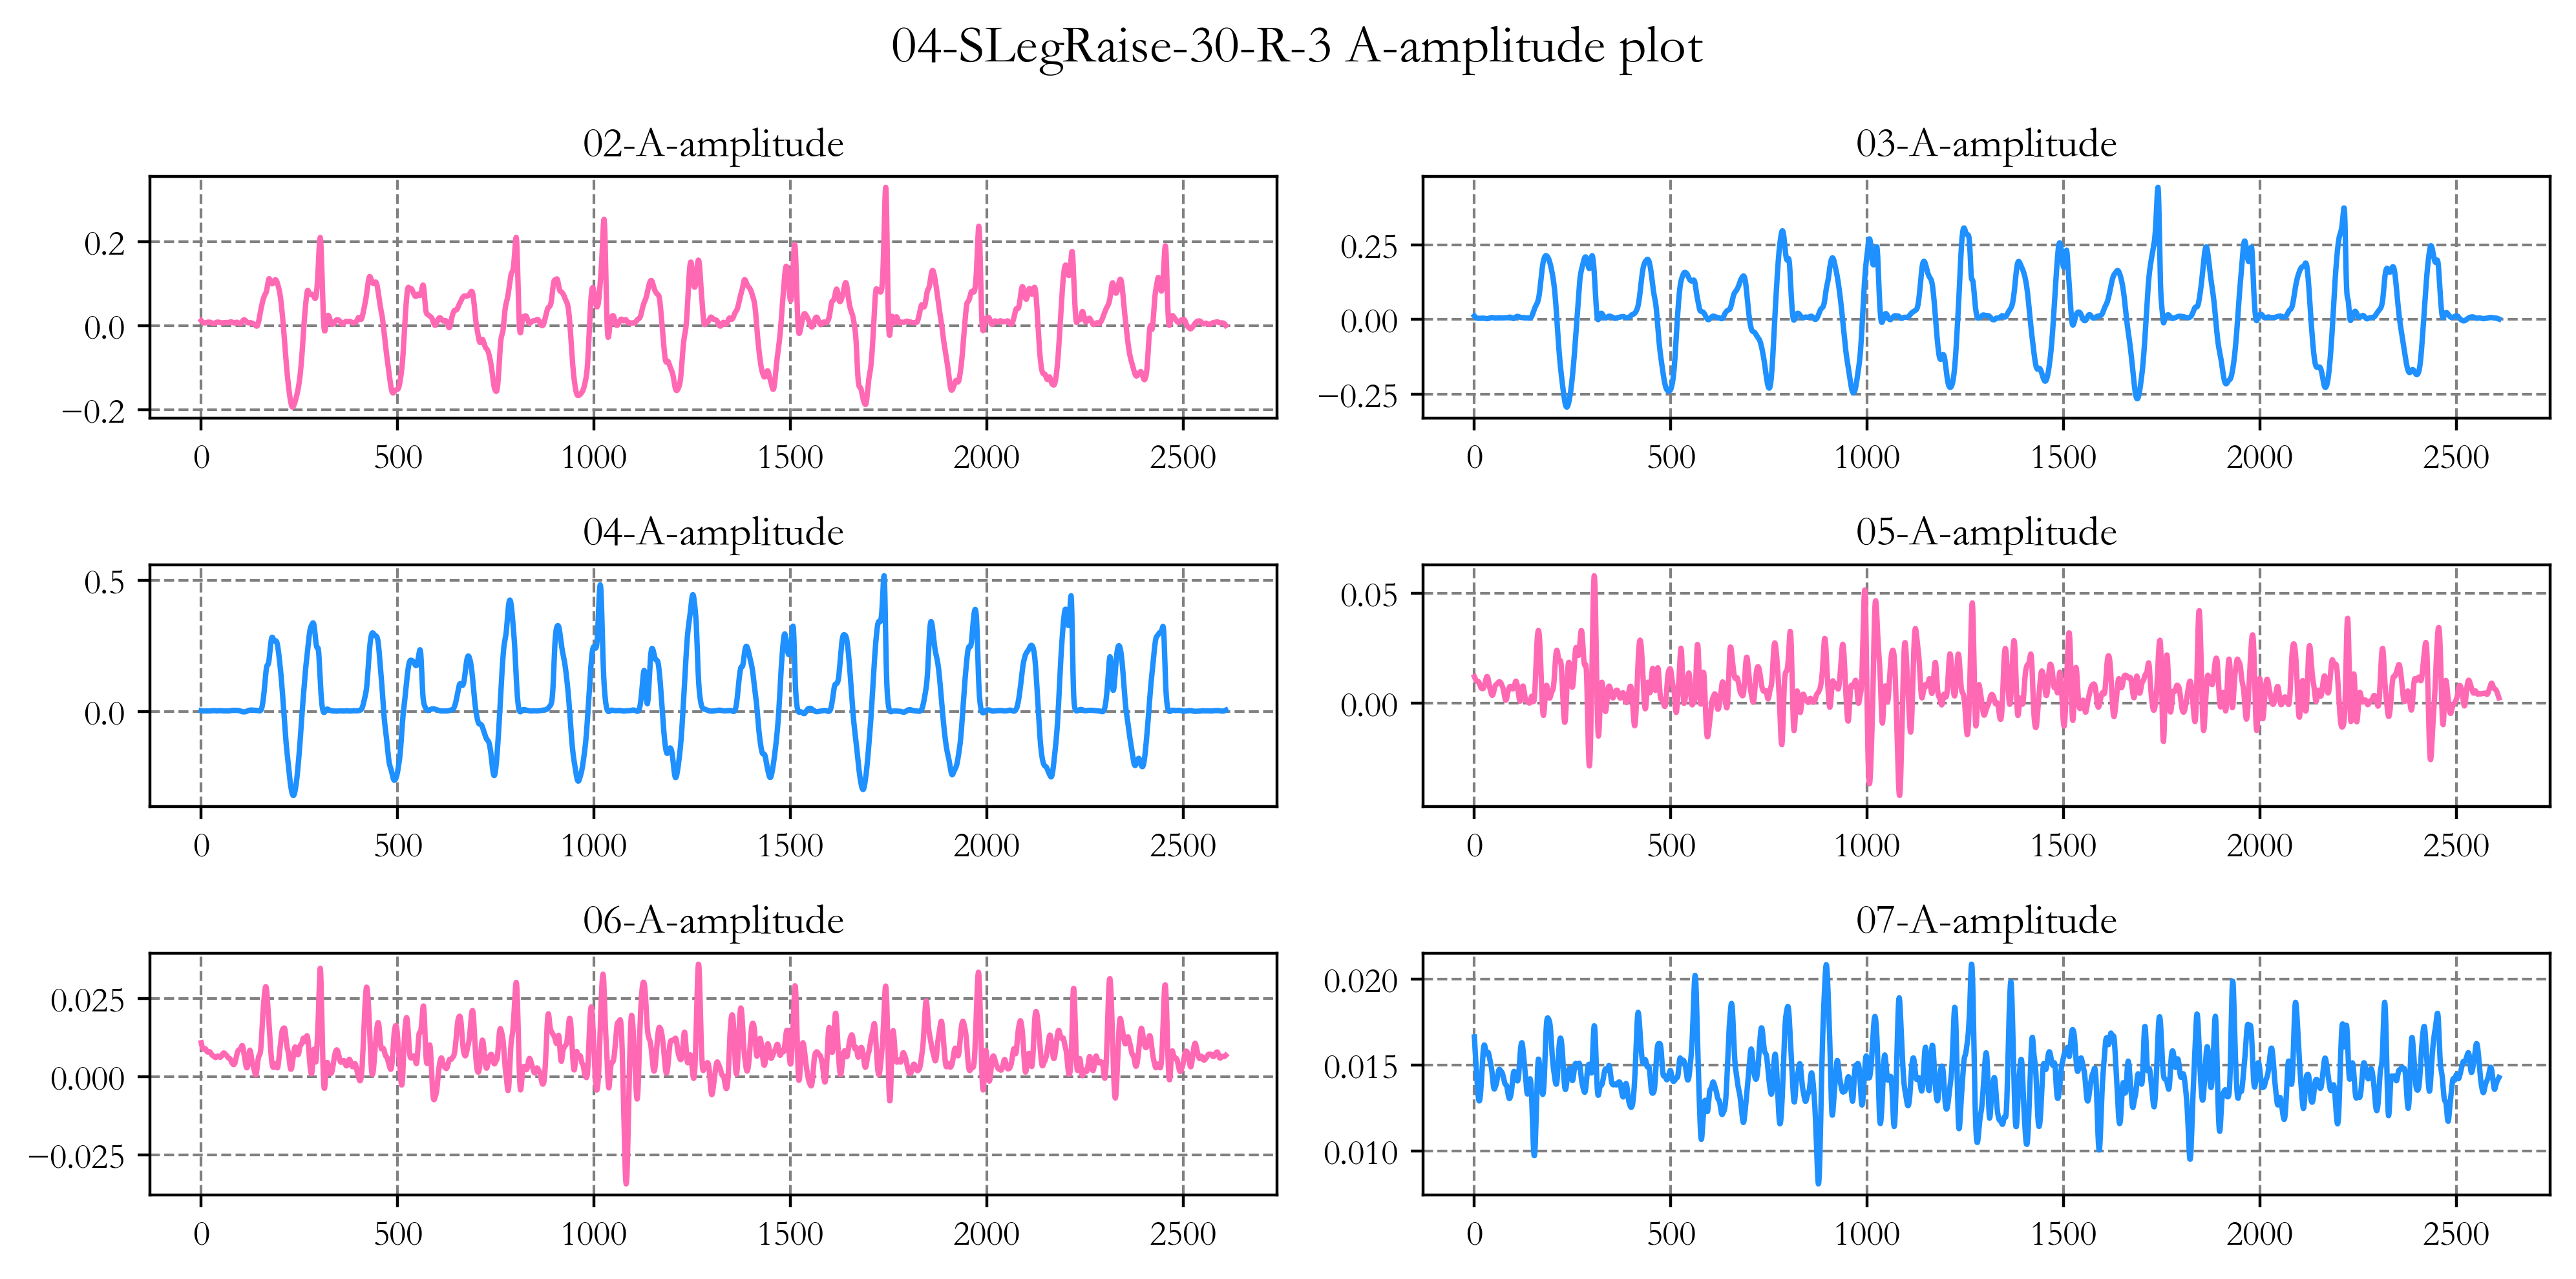

In [9201]:
# 调整子图纵向间隔
plt.subplots_adjust(hspace=0.8)
fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(nrows=3, ncols=2, figsize=(10,5))

ax1.plot(amplitude1, linewidth=1.5, color='hotpink')
ax2.plot(amplitude2, linewidth=1.5, color='dodgerblue')
ax3.plot(amplitude3, linewidth=1.5, color='dodgerblue')
ax4.plot(amplitude4, linewidth=1.5, color='hotpink')
ax5.plot(amplitude5, linewidth=1.5, color='hotpink')
ax6.plot(amplitude6, linewidth=1.5, color='dodgerblue')

ax1.set_title('02-A-amplitude')
ax2.set_title('03-A-amplitude')
ax3.set_title('04-A-amplitude')
ax4.set_title('05-A-amplitude')
ax5.set_title('06-A-amplitude')
ax6.set_title('07-A-amplitude')

plt.suptitle(file_type + ' A-amplitude plot', fontsize='15')
ax1.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax1.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax2.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax2.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax3.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax3.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax4.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax4.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax5.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax5.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax6.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax6.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)

# ax1.legend();ax2.legend();ax3.legend();ax4.legend();ax5.legend();ax6.legend()

plt.tight_layout()

<Figure size 2000x400 with 0 Axes>

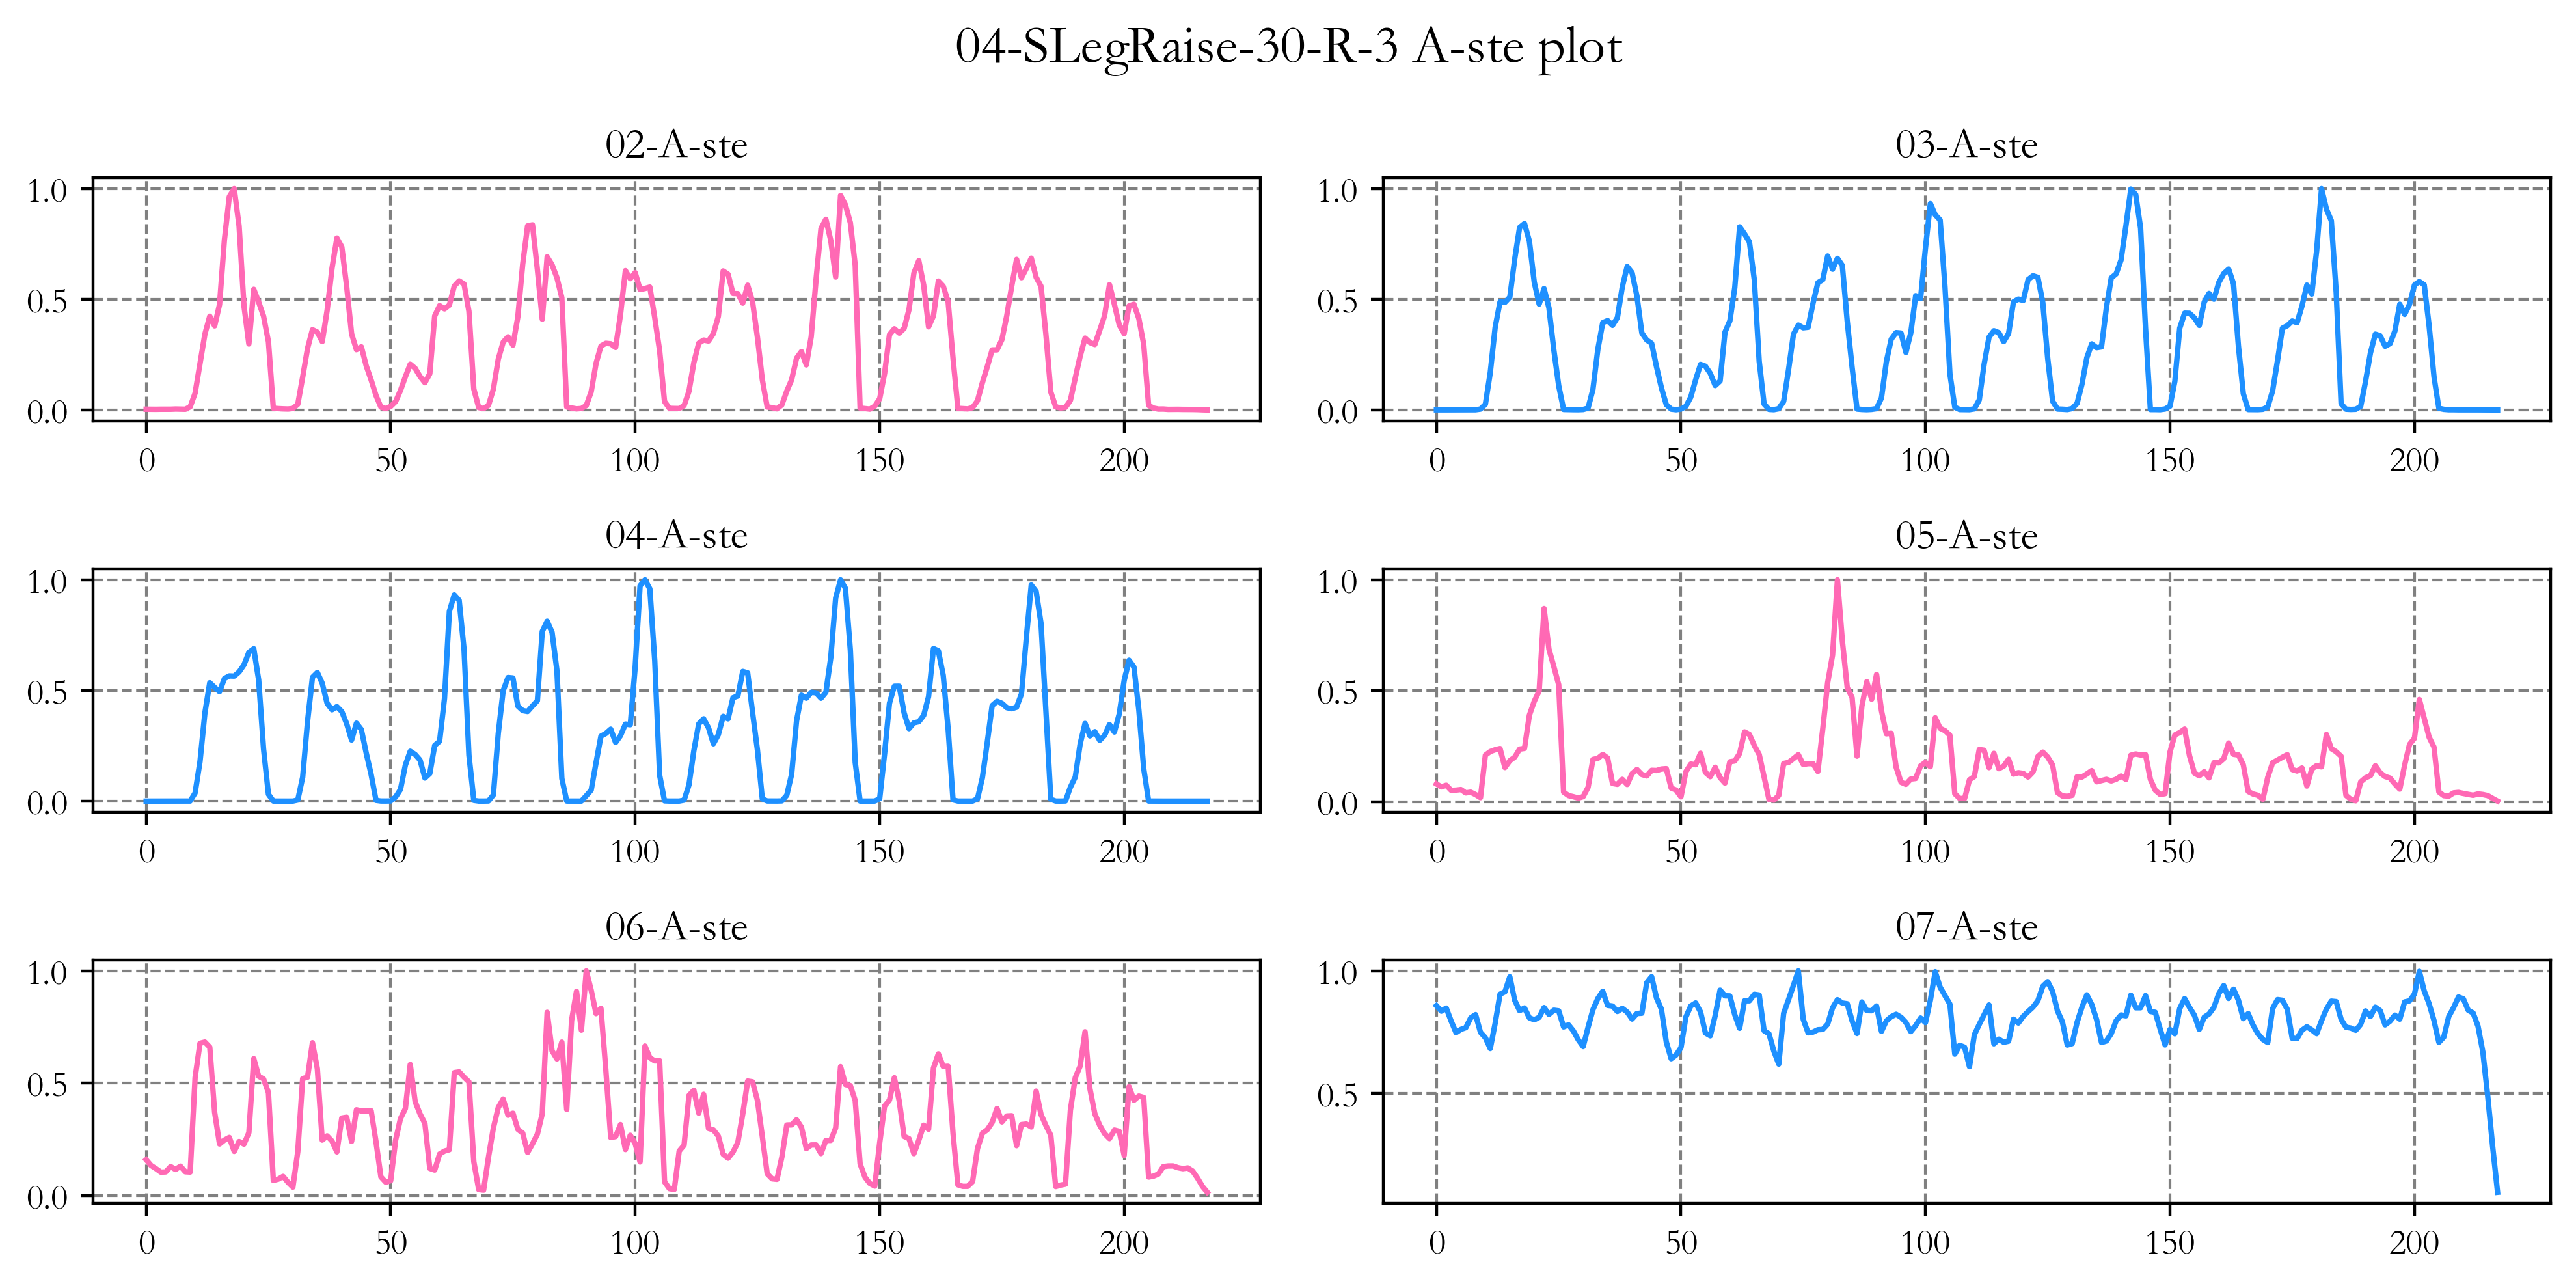

In [9202]:
# 调整子图纵向间隔
plt.subplots_adjust(hspace=0.8)
fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(nrows=3, ncols=2, figsize=(10,5))

ax1.plot(ste1, linewidth=1.5, color='hotpink')
ax2.plot(ste2, linewidth=1.5, color='dodgerblue')
ax3.plot(ste3, linewidth=1.5, color='dodgerblue')
ax4.plot(ste4, linewidth=1.5, color='hotpink')
ax5.plot(ste5, linewidth=1.5, color='hotpink')
ax6.plot(ste6, linewidth=1.5, color='dodgerblue')
# ax1.plot(raw_ste1, linewidth=1.5, color='hotpink')
# ax2.plot(raw_ste2, linewidth=1.5, color='dodgerblue')
# ax3.plot(raw_ste3, linewidth=1.5, color='dodgerblue')
# ax4.plot(raw_ste4, linewidth=1.5, color='hotpink')
# ax5.plot(raw_ste5, linewidth=1.5, color='hotpink')
# ax6.plot(raw_ste6, linewidth=1.5, color='dodgerblue')

ax1.set_title('02-A-ste')
ax2.set_title('03-A-ste')
ax3.set_title('04-A-ste')
ax4.set_title('05-A-ste')
ax5.set_title('06-A-ste')
ax6.set_title('07-A-ste')

plt.suptitle(file_type + ' A-ste plot', fontsize='15')
ax1.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax1.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax2.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax2.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax3.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax3.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax4.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax4.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax5.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax5.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax6.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax6.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)

# ax1.legend();ax2.legend();ax3.legend();ax4.legend();ax5.legend();ax6.legend()

plt.tight_layout()

<Figure size 2000x400 with 0 Axes>

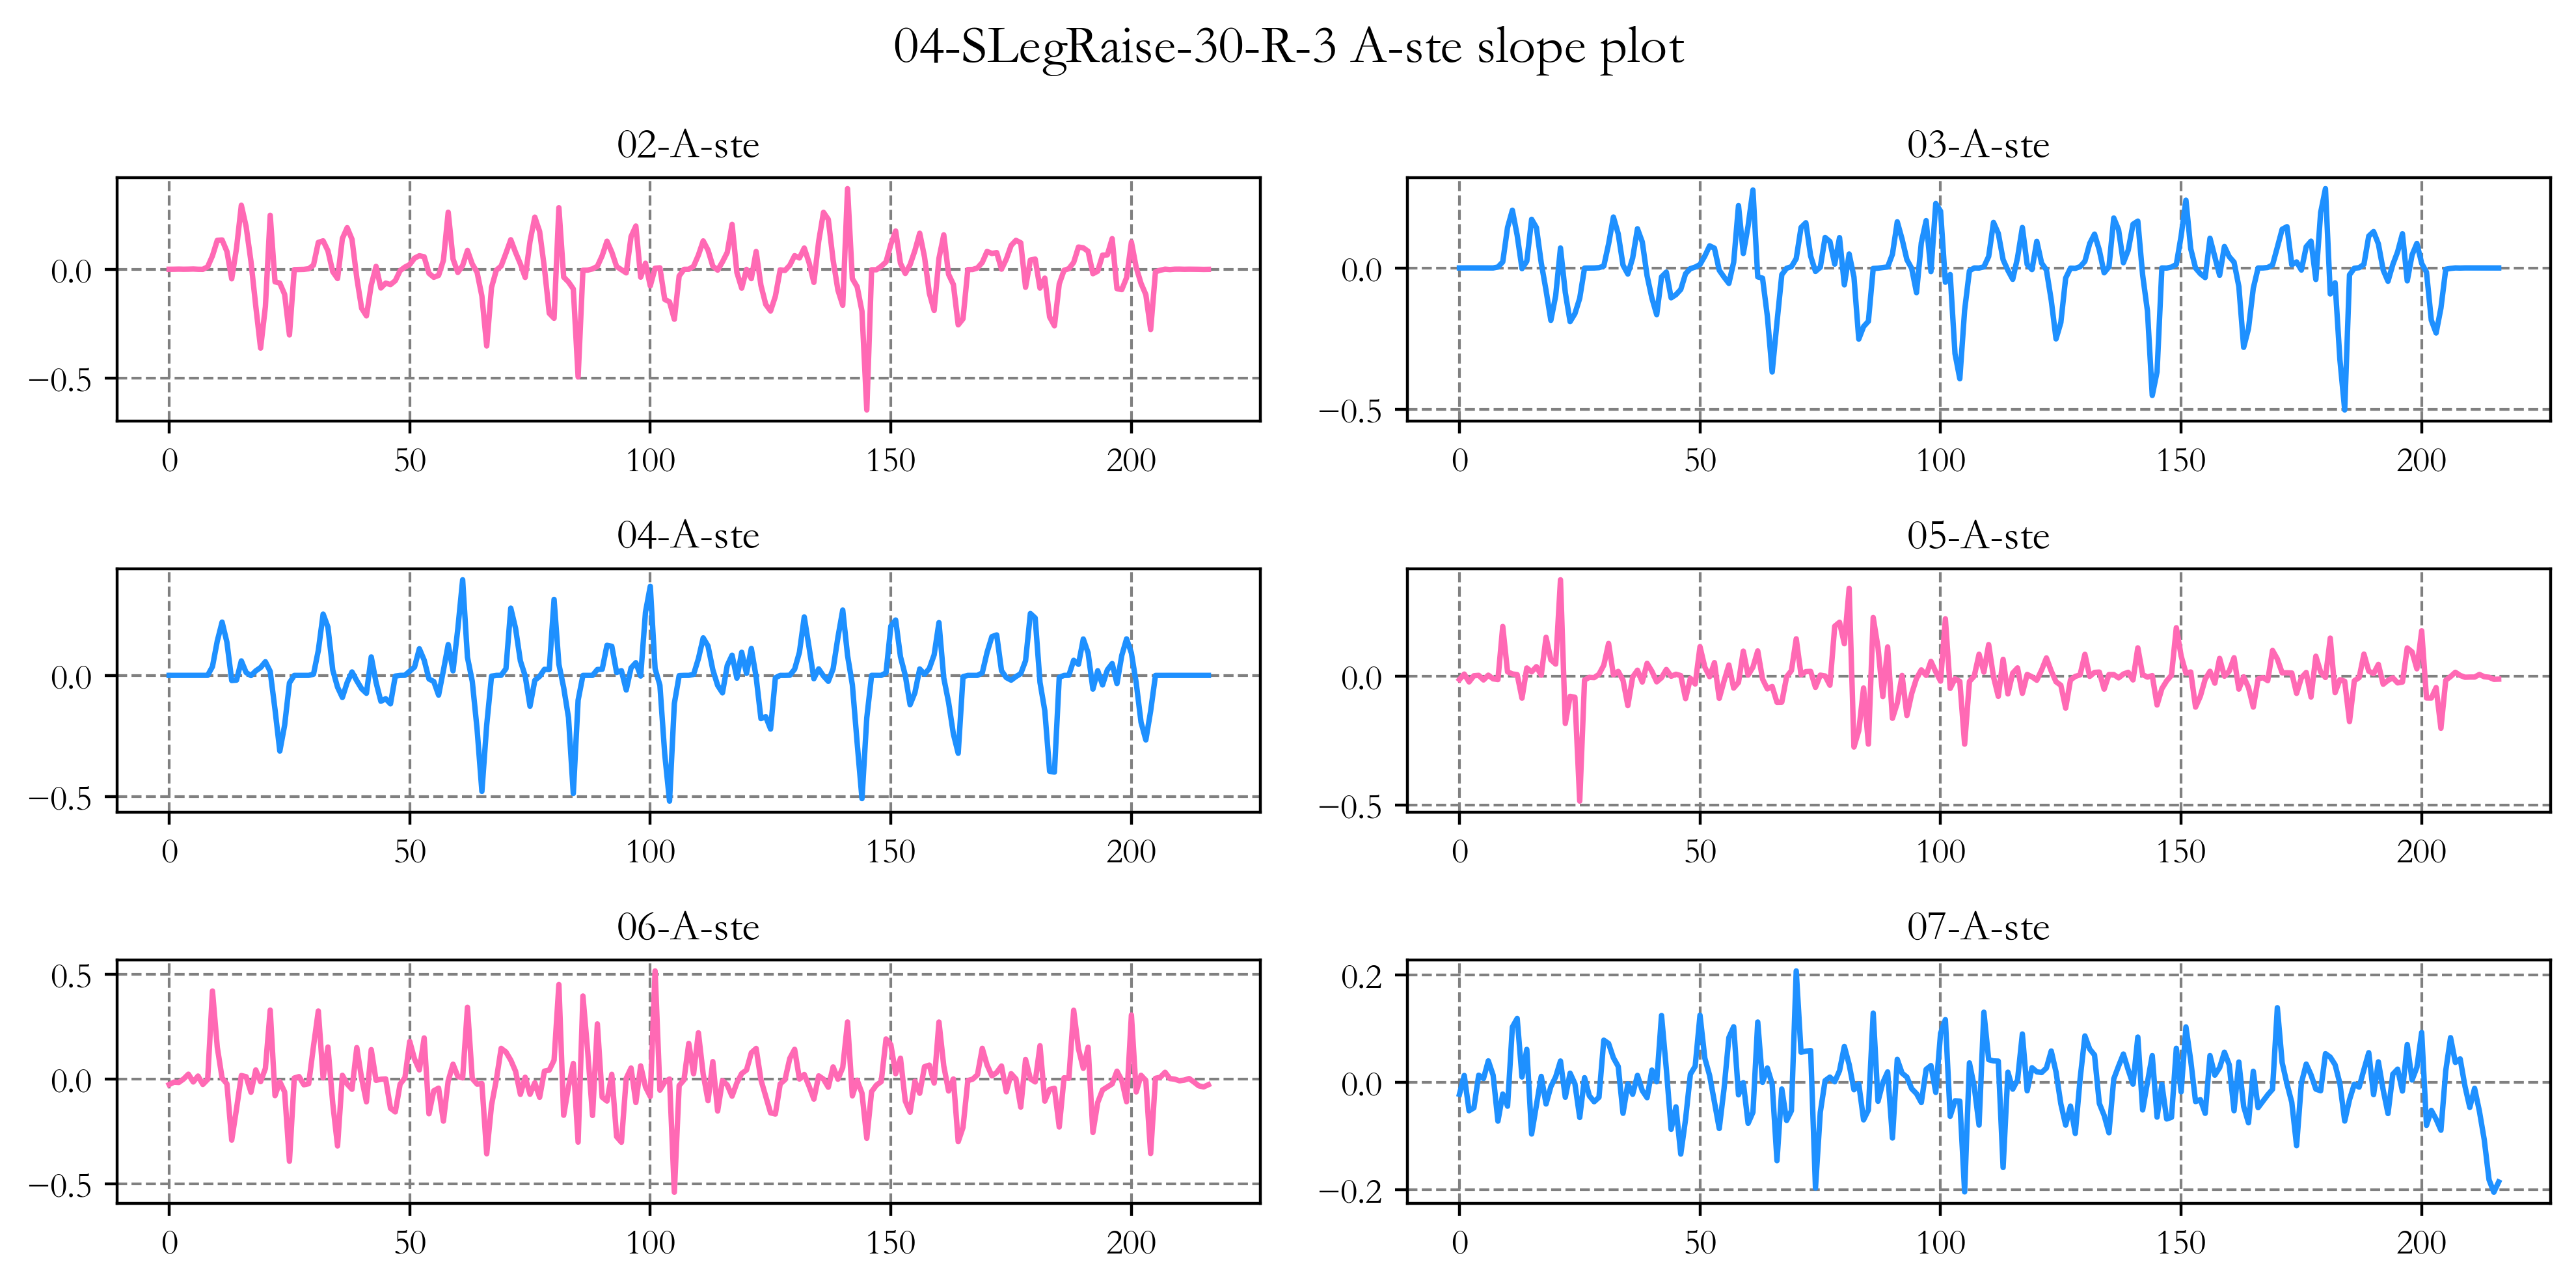

In [9203]:
# 调整子图纵向间隔
plt.subplots_adjust(hspace=0.8)
fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(nrows=3, ncols=2, figsize=(10,5))

ax1.plot(np.diff(ste1), linewidth=1.5, color='hotpink')
ax2.plot(np.diff(ste2), linewidth=1.5, color='dodgerblue')
ax3.plot(np.diff(ste3), linewidth=1.5, color='dodgerblue')
ax4.plot(np.diff(ste4), linewidth=1.5, color='hotpink')
ax5.plot(np.diff(ste5), linewidth=1.5, color='hotpink')
ax6.plot(np.diff(ste6), linewidth=1.5, color='dodgerblue')

ax1.set_title('02-A-ste')
ax2.set_title('03-A-ste')
ax3.set_title('04-A-ste')
ax4.set_title('05-A-ste')
ax5.set_title('06-A-ste')
ax6.set_title('07-A-ste')

plt.suptitle(file_type + ' A-ste slope plot', fontsize='15')
ax1.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax1.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax2.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax2.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax3.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax3.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax4.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax4.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax5.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax5.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax6.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax6.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)

# ax1.legend();ax2.legend();ax3.legend();ax4.legend();ax5.legend();ax6.legend()

plt.tight_layout()

<h5 id="click">利用STE以及STE斜率进行分割</h5>

<a href="#top">顶部</a> </br>
<a href="#tail">尾部</a>

In [9204]:
file_type

'04-SLegRaise-30-R-3'

In [9205]:
# 逐个分割每一个IMU的STE
# R :1,2     L :4,5
# eval 代表值
name = 'ste2'; ste = eval(name); amplitude = eval(name.replace('ste', 'amplitude'))

raw_name ='raw_' + name; ste_raw = eval(raw_name); amplitude_raw = eval(raw_name.replace('ste', 'amplitude'))

name, raw_name, name.replace('ste', 'amplitude')

('ste2', 'raw_ste2', 'amplitude2')

In [9206]:
ste.describe(percentiles=[.5, .10, .15, .20, .25, .30, .35, .40, .45, .60, .65, .7, .75, .8, .85, .9, .95])

count    218.000000
mean       0.301154
std        0.274114
min        0.000018
10%        0.001132
15%        0.001694
20%        0.002847
25%        0.005605
30%        0.025319
35%        0.092915
40%        0.164488
45%        0.230010
50%        0.299062
60%        0.371511
65%        0.401946
70%        0.476719
75%        0.500662
80%        0.555408
85%        0.588664
90%        0.660233
95%        0.824848
max        1.000000
Name: 03-A-ste, dtype: float64

In [9207]:
ste_choose = ste.describe(percentiles=[.5, .10, .15, .20, .25, .30, .35, .40, .45, .60, .65, .7, .75, .8, .85, .9, .95])

In [9208]:
slope = np.diff(ste)
slope = pd.Series(slope)
slope.describe(percentiles=[.5, .10, .15, .20, .25, .30, .35, .40, .60, .65, .7, .75])

count    217.000000
mean      -0.000002
std        0.120047
min       -0.503012
10%       -0.156158
15%       -0.087346
20%       -0.044838
25%       -0.026178
30%       -0.013380
35%       -0.002526
40%       -0.000521
50%        0.000044
60%        0.011611
65%        0.020295
70%        0.039649
75%        0.062868
max        0.280806
dtype: float64

In [9209]:
sth = slope.describe(percentiles=[.5, .10, .15, .20, .25, .30, .35, .40, .60, .7, .75, .8, .85])['75%']
eth = slope.describe(percentiles=[.5, .10, .15, .20, .25, .30, .35, .40, .60, .7, .75, .8, .85])['75%']

sth, eth

(0.0628676387629632, 0.0628676387629632)

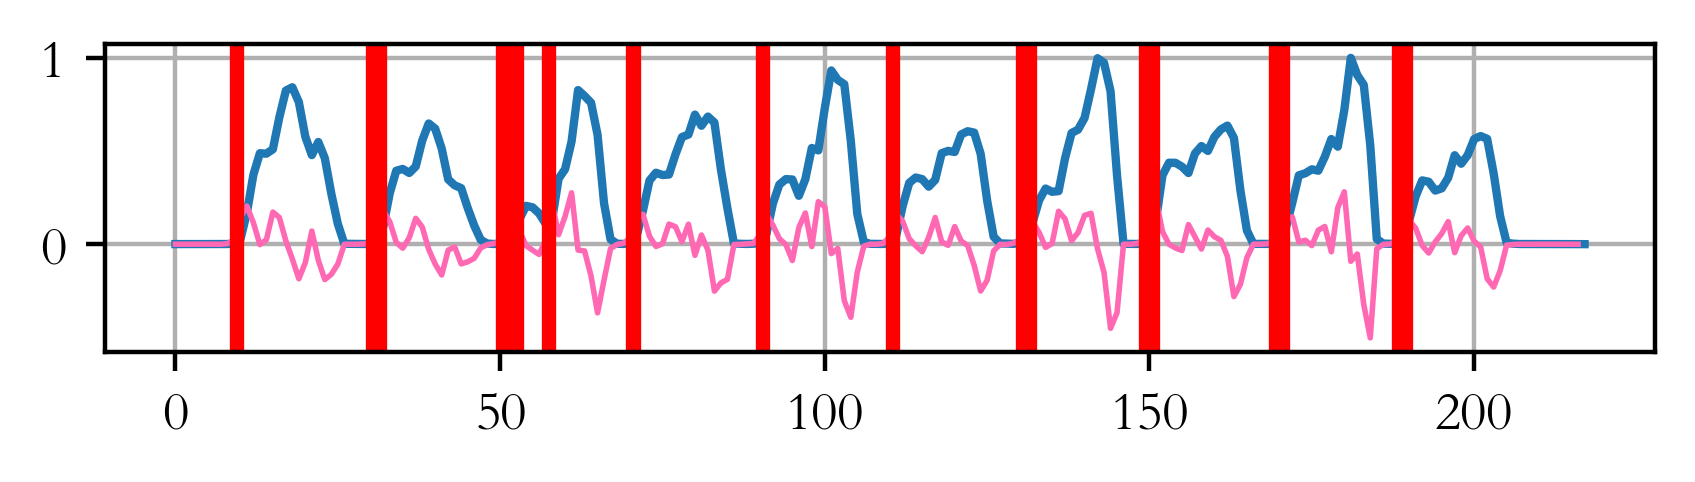

In [9210]:
start_list = list()
for i in range(len(slope)):
    # if (np.abs(slope[i]) > sth) and (np.abs(ste[i+2]) >= 5*ste_choose['60%']) and (ste[i] < ste_choose['60%']):
    if (np.abs(slope[i]) >= 0.1*sth) and (ste[i+1] >= ste[i]) and (ste[i] <= ste_choose['40%']):
        start_list.append(i)

plt.grid()
plt.plot(ste)
plt.plot(slope, color='hotpink', linewidth=1)
for i in start_list:
    plt.axvline(i, color='red')

In [9211]:
# ste_choose['60%'], start_list, sth, slope[9], slope[66] > slope[65]

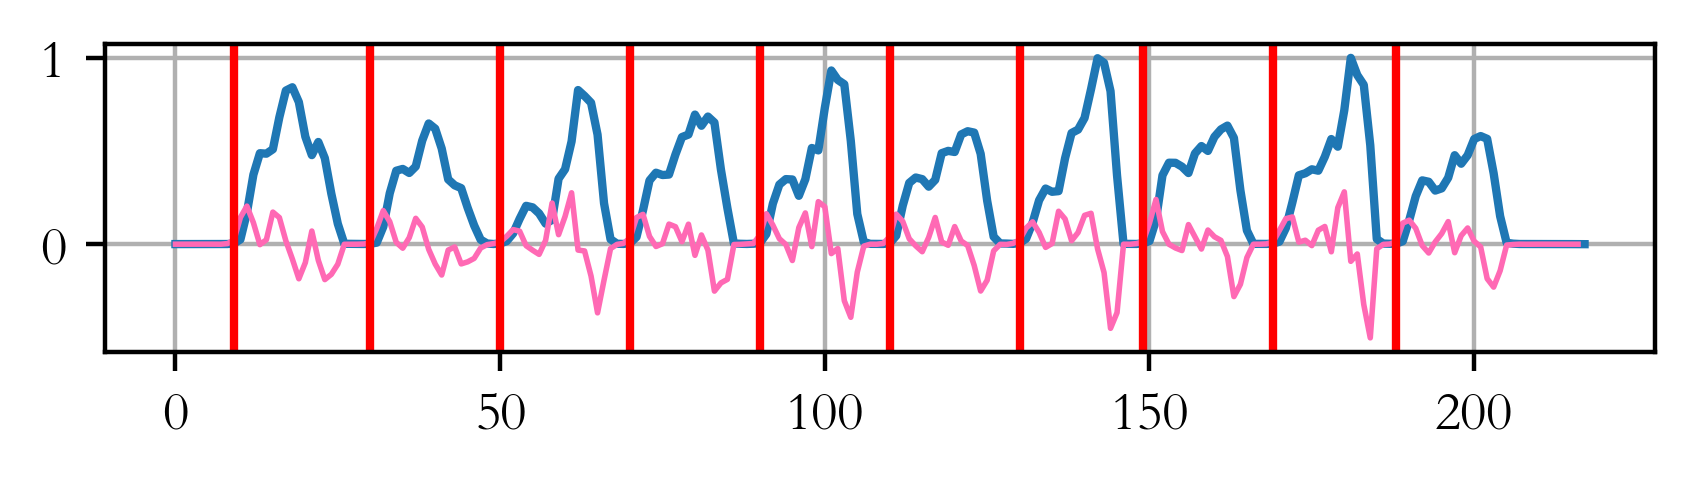

In [9212]:
filter_list_start = list()
start = 0
for i in range(len(start_list)):
    if i==0:
        j = i
        while(slope[start_list[j]+1] <= -1*sth):
        # while(j <= 2):
            j += 1
        filter_list_start.append(start_list[j])
        start = start_list[j]
    else:
        # if start_list[i] - start >= 10 and start_list[i] - filter_list_start[-1] >= 16 and len(filter_list_start)<10:
        if start_list[i] - start >= 13 and start_list[i] - filter_list_start[-1] >= 15 and len(filter_list_start)<=11:
            filter_list_start.append(start_list[i])
            start = start_list[i]
filter_list_start

plt.grid()
plt.plot(ste)
plt.plot(slope, color='hotpink', linewidth=1)
for i in filter_list_start:
    plt.axvline(i, color='red')

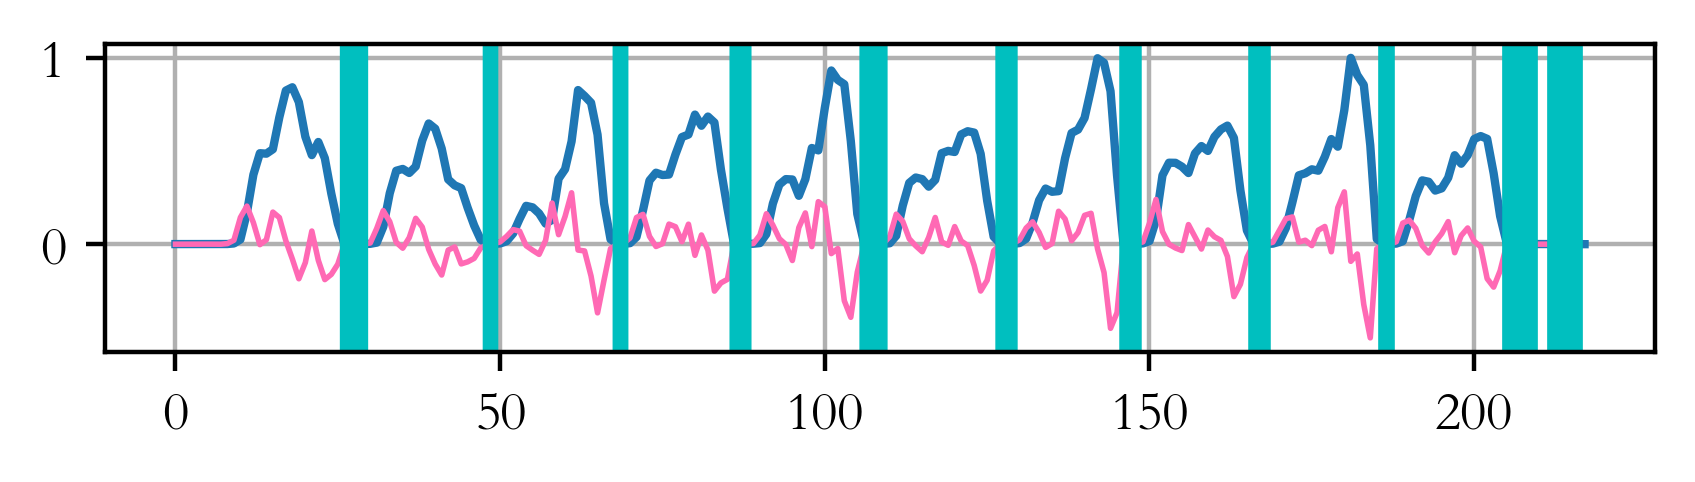

In [9213]:
end_list = list()

for i in filter_list_start:           
    for j in range(len(slope)-i):
        # if np.abs(slope[i+j]) <= 1*eth and ste[i+j-1] >= ste_choose['60%'] and ste[i+j] < ste_choose['60%']:
        if np.abs(slope[i+j]) <= 20*eth and ste[i+j-1] >= ste[i+j] and ste[i+j] <= 0.6*ste_choose['30%']:
            end_list.append(i+j)

plt.grid()
plt.rcParams['font.sans-serif']=['STSong']
plt.rcParams['figure.figsize'] = [5, 1]
plt.rcParams["figure.dpi"] = 400 # 设置分辨率
plt.plot(ste)
plt.plot(slope, color='hotpink', linewidth=1)
for i in end_list:
    plt.axvline(i, color='c')
# for i in filter_list_start:
#     plt.axvline(i, color='red')

In [9214]:
eth, end_list[0]

(0.0628676387629632, 26)

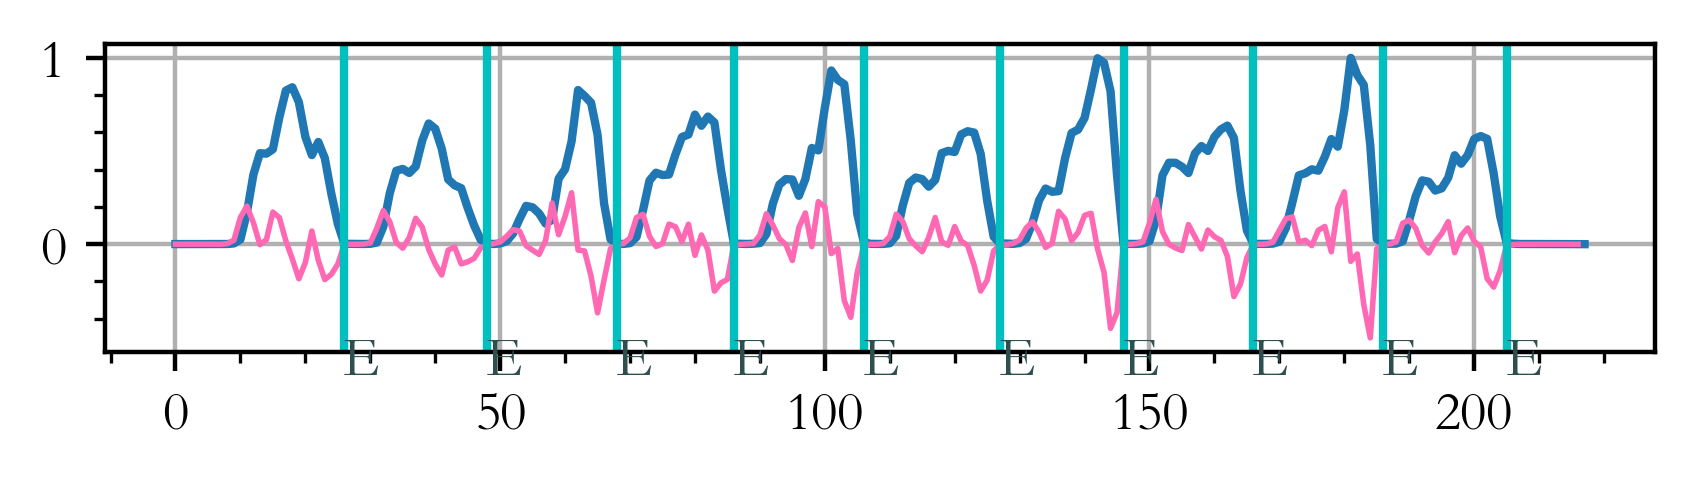

In [9215]:
filter_list_end = list()
start = 0
for i in range(len(end_list)):
    if i==0:
        j = i
        # 如果第一个结束点与第二个开始点之间距离小于一定值
        # while(filter_list_start[1] - end_list[j] >= 3 and end_list[j] - filter_list_start[0]>= 5):
        while(end_list[j] - filter_list_start[0]<= 14):
            j += 1
        filter_list_end.append(end_list[j])
        start = end_list[j]        
    else:
        # end_list[i] - start >= 8 end_list相邻两条结束线之间距离要大于一定值
        # end_list[i] - filter_list_end[-1] >=10 下一条结束线和最终筛选的上一条线要大于一定值
        # if end_list[i] - start >=16 and end_list[i] - filter_list_end[-1] >= 19 and len(filter_list_end)<10:
        if end_list[i] - start >=10 and end_list[i] - filter_list_end[-1] >= 16 and len(filter_list_end)<len(filter_list_start):
            filter_list_end.append(end_list[i])
            start = end_list[i]

plt.grid()
# plt.rcParams['figure.figsize'] = [5, 2]
plt.plot(ste)
plt.plot(slope, color='hotpink', linewidth=1)
# 显示副刻度线
plt.minorticks_on()
# plt.tight_layout()
for i in filter_list_end:
    plt.axvline(i, color='c')
    plt.text(i-0.2, -0.7, 'E', color='darkslategrey')
# for i in filter_list_start:
#     plt.axvline(i, color='red')
#     plt.text(i, 0.7, 'S')

In [9216]:
# 0.5s , 0.125s
frame_length, hop_length

(48, 12)

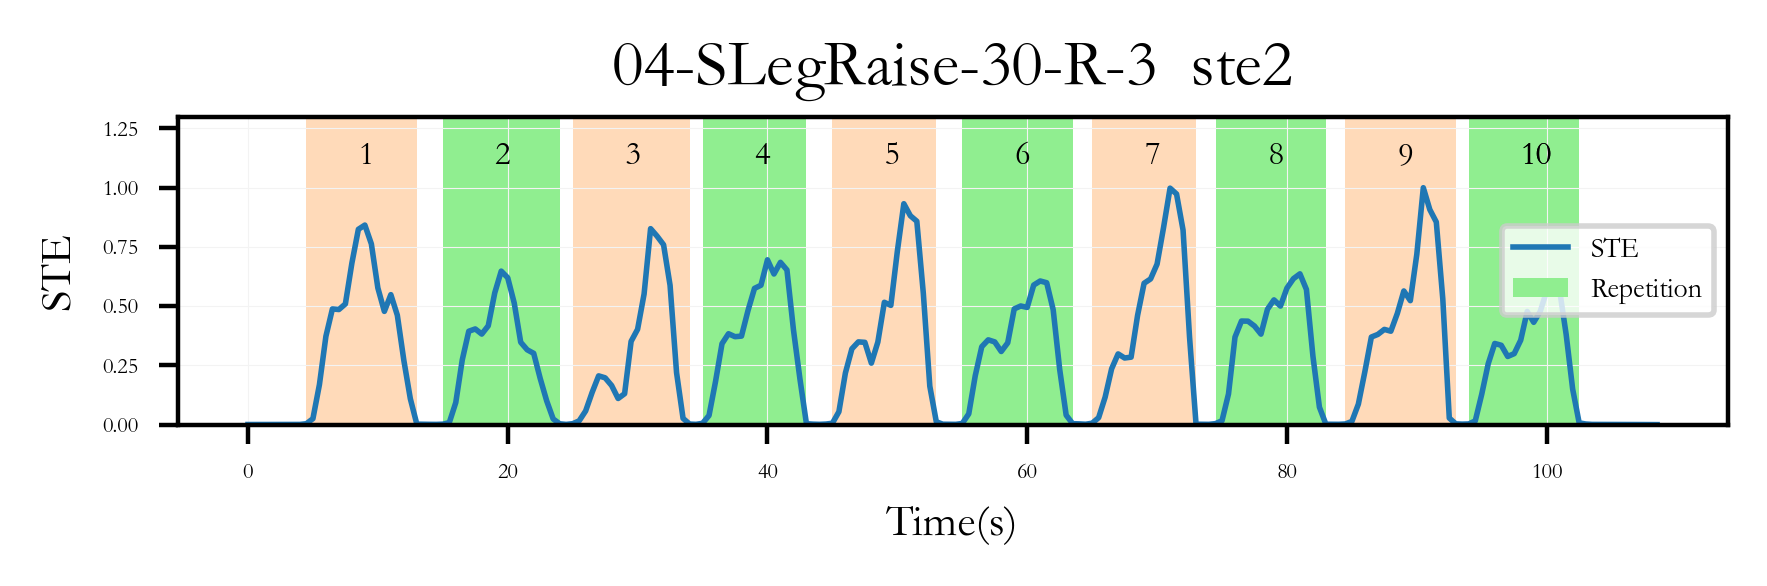

In [9217]:
# filter_list_start = [21, 45, 69, 93, 119, 148, 172, 196, 221, 249]
# filter_list_end = [37, 61, 88, 113, 139, 164, 188, 212, 238, 268]

plt.grid(color='#f3f3f3', linewidth=0.2)
plt.rcParams['figure.figsize'] = [4, 1]
plt.plot(np.arange(len(ste))/2,ste, label='STE', linewidth=1)

# 显示副刻度线
# plt.minorticks_on()
# plt.xlim(0, len(ste)+10)
plt.ylim(0, 1.3)
color = itertools.cycle(['peachpuff', 'lightgreen'])

# plt.Rectangle (xy(2元组),width,height,angle,fill)
for i in range(len(filter_list_end)):
    rect = Rectangle((filter_list_start[i]/2, 0), filter_list_end[i]/2-filter_list_start[i]/2, 1.3, 
    facecolor=next(color))
    plt.gca().add_patch(rect)
    plt.text(filter_list_start[i]/2+(filter_list_end[i]/2-filter_list_start[i]/2)//2, 1.1, i+1, fontsize=6)

rect = Rectangle((filter_list_start[-1]/2, 0), filter_list_end[-1]/2-filter_list_start[-1]/2, 1.3, 
facecolor='lightgreen', label='Repetition')
plt.gca().add_patch(rect)
plt.text(filter_list_start[-1]/2+(filter_list_end[-1]/2-filter_list_start[-1]/2)//2, 1.1, i+1, fontsize=6)

plt.xlabel('Time(s)', fontsize=8)
plt.ylabel('STE', fontsize=8)
plt.title(file_type + '  ' + name, fontsize=12)

# ticks = np.arange(6)
plt.tick_params(labelsize=4)
plt.legend(fontsize=5, loc='center right')

In [9218]:
len(filter_list_start), len(filter_list_end)

(10, 10)

In [9219]:
filter_list_start, filter_list_end 

([9, 30, 50, 70, 90, 110, 130, 149, 169, 188],
 [26, 48, 68, 86, 106, 127, 146, 166, 186, 205])

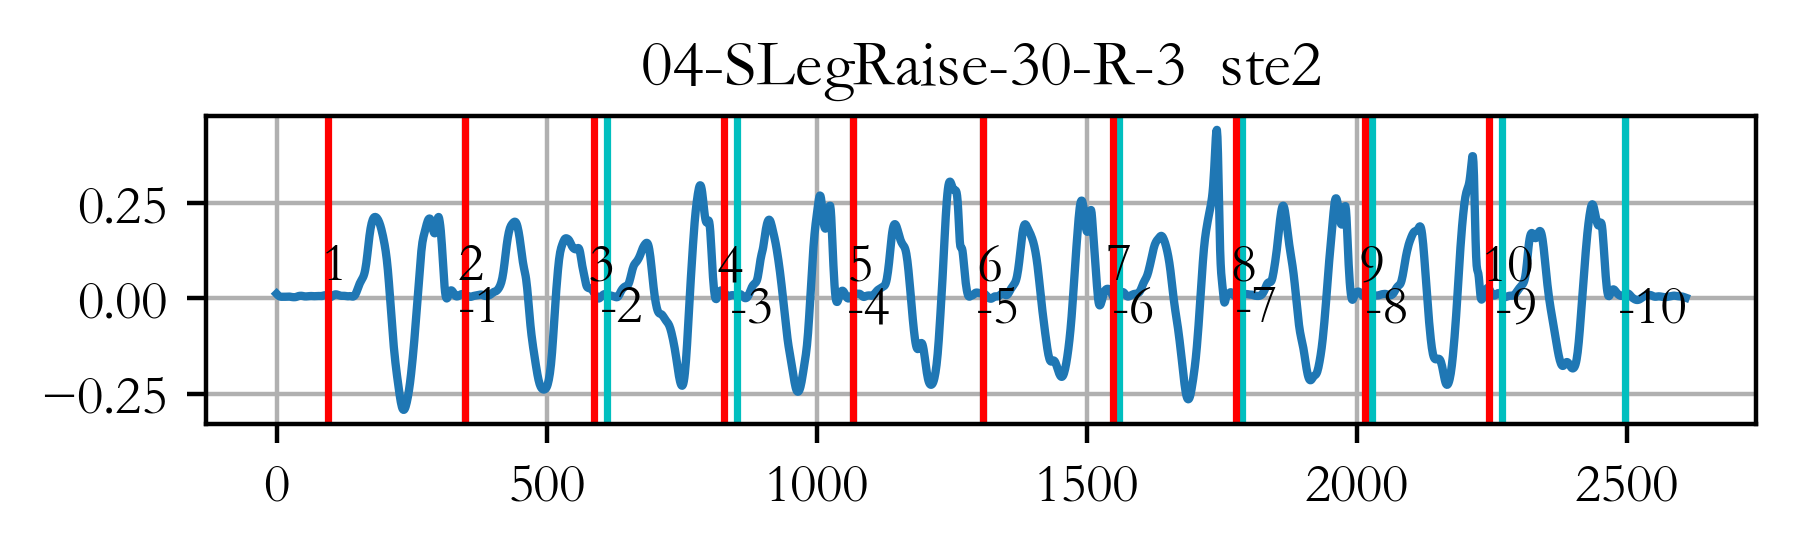

In [9220]:
# filter_list_start = [21, 45, 69, 93, 119, 148, 172, 196, 221, 249]
# filter_list_end = [37, 61, 88, 113, 139, 164, 188, 212, 238, 268]

# 查看最后加速度幅值分割情况
plt.rcParams['figure.figsize'] = [5, 1]
plt.title(file_type + '  ' + name, fontsize=12)
plt.plot(amplitude)
plt.grid()

for i in range(len(filter_list_start)):
    plt.axvline(hop_length*(filter_list_start[i]-1), color='red', linewidth=1.3)
    plt.text(hop_length*(filter_list_start[i]-2)-1,0.05,i+1)
    plt.axvline(hop_length*(filter_list_end[i]-1)+frame_length, color='c', linewidth=1.3)
    plt.text(hop_length*(filter_list_end[i]-2)+frame_length-1,-0.06,-i-1)

In [9221]:
num = str(eval(name.replace('ste','')) + 1)
# num 'ste4' -> '5'，映射回原始编号以对应csv文件编号来取对应数据
raw_label_list = []

# 获取单个imu短时能量的所有加速度列标签
for label in df.columns:
    if fnmatch(label, '*'+ num + '-A*'):
        raw_label_list.append(label)
        # print(label)

# 只获取加速度数据，忽略陀螺仪数据
df_raw_data = df_raw.loc[:,raw_label_list].copy()
df_filter_data = df.loc[:,raw_label_list].copy()

In [9222]:
num, df.shape, df_raw_data.shape, df_filter_data.shape

('3', (2610, 42), (2610, 3), (2610, 3))

<Figure size 2000x400 with 0 Axes>

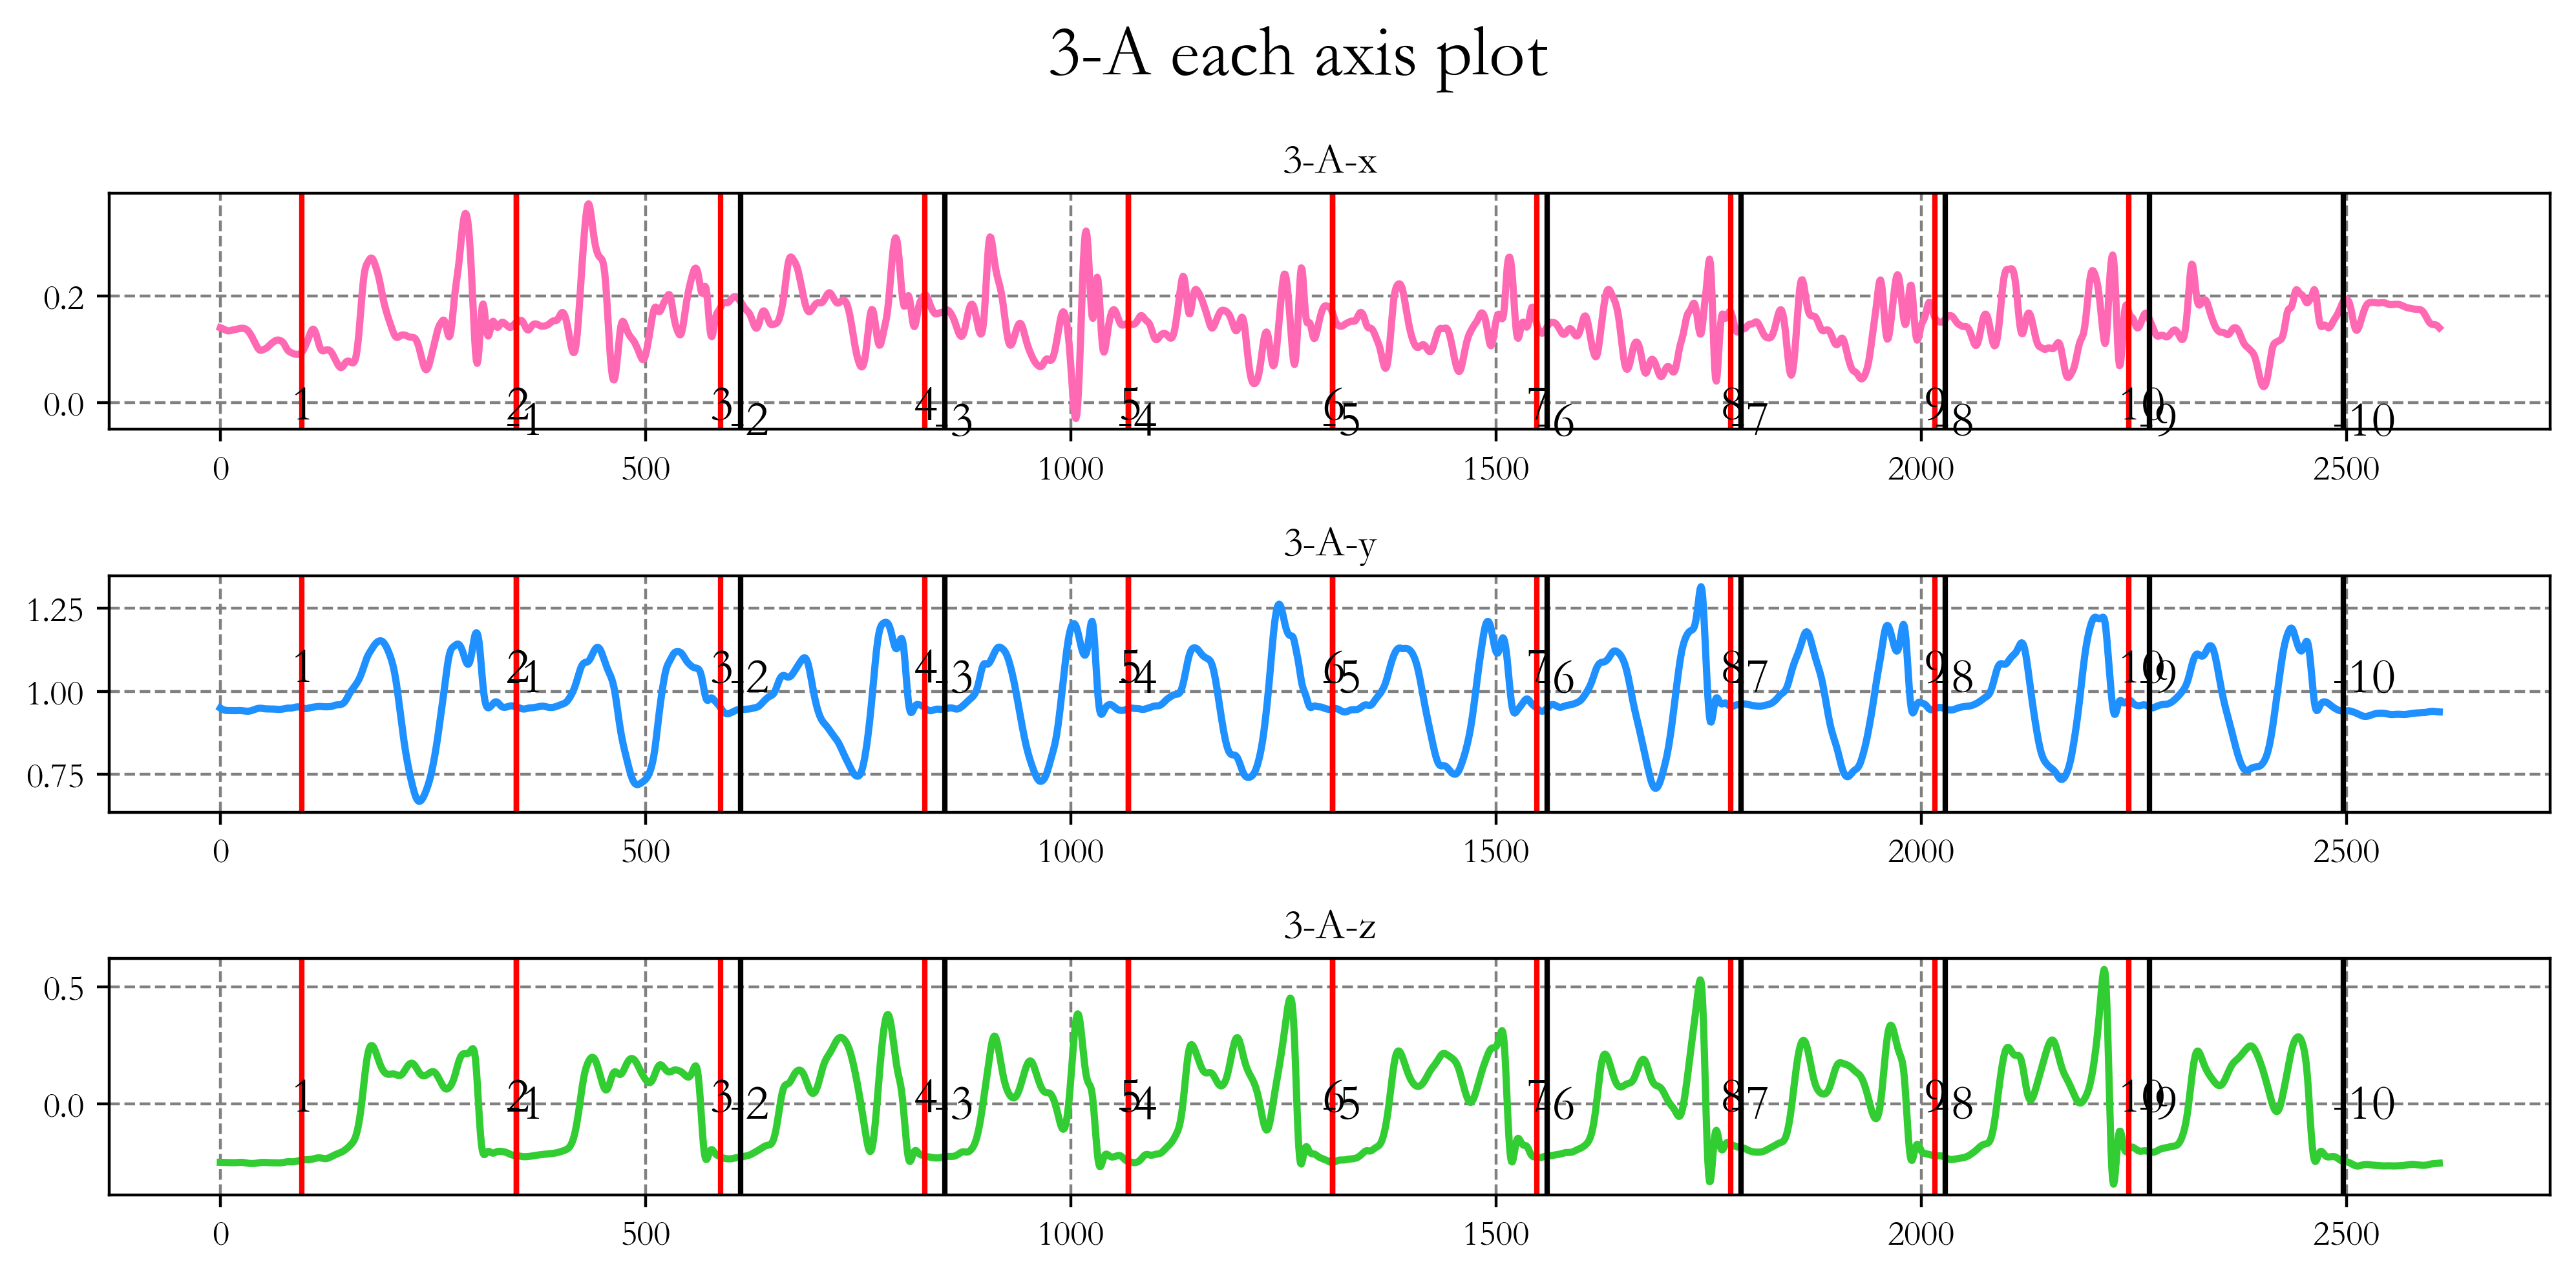

In [9223]:
# 查看加速度原始数据分割情况
# 调整子图纵向间隔
plt.subplots_adjust(hspace=3)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,5))

# ax1.plot(df_raw[raw_label_list[0]], color='hotpink')
# ax2.plot(df_raw[raw_label_list[1]], color='dodgerblue')
# ax3.plot(df_raw[raw_label_list[2]], color='limegreen')
ax1.plot(df[raw_label_list[0]], color='hotpink', linewidth=2)
ax2.plot(df[raw_label_list[1]], color='dodgerblue', linewidth=2)
ax3.plot(df[raw_label_list[2]], color='limegreen', linewidth=2)

ax1.set_title(num+'-A-x')
ax2.set_title(num+'-A-y')
ax3.set_title(num+'-A-z')

plt.suptitle(num+'-A each axis plot', fontsize='20')
ax1.grid(True, which="major", linestyle="--", color="gray")
ax1.grid(True, which="minor", linestyle=":", color="lightgray")
ax2.grid(True, which="major", linestyle="--", color="gray")
ax2.grid(True, which="minor", linestyle=":", color="lightgray")
ax3.grid(True, which="major", linestyle="--", color="gray")
ax3.grid(True, which="minor", linestyle=":", color="lightgray")

for i in range(len(filter_list_start)):
    ax1.axvline(hop_length*(filter_list_start[i]-1), color='red'); ax1.text(hop_length*(filter_list_start[i]-2)-1,-0.03,i+1,fontsize=14)
    ax1.axvline(hop_length*(filter_list_end[i]-1)+frame_length, color='black'); ax1.text(hop_length*(filter_list_end[i]-2)+frame_length-1,-0.06,-i-1,fontsize=14)
    ax2.axvline(hop_length*(filter_list_start[i]-1), color='red'); ax2.text(hop_length*(filter_list_start[i]-2)-1,1.03,i+1,fontsize=14)
    ax2.axvline(hop_length*(filter_list_end[i]-1)+frame_length, color='black'); ax2.text(hop_length*(filter_list_end[i]-2)+frame_length-1,1,-i-1,fontsize=14)
    ax3.axvline(hop_length*(filter_list_start[i]-1), color='red'); ax3.text(hop_length*(filter_list_start[i]-2)-1,-0.03,i+1,fontsize=14)
    ax3.axvline(hop_length*(filter_list_end[i]-1)+frame_length, color='black'); ax3.text(hop_length*(filter_list_end[i]-2)+frame_length-1,-0.06,-i-1,fontsize=14)

plt.tight_layout()

In [9224]:
# L ste4 ste5
# R ste1 ste2
print(file_type, name.upper(), raw_label_list)
print(len(filter_list_start), len(filter_list_end), len(ste))
print(filter_list_start)
print(filter_list_end)

04-SLegRaise-30-R-3 STE2 ['03-A-x', '03-A-y', '03-A-z']
10 10 218
[9, 30, 50, 70, 90, 110, 130, 149, 169, 188]
[26, 48, 68, 86, 106, 127, 146, 166, 186, 205]


In [9225]:
# 保存短时能量各片段的分割端点，备以后用
start_points_list = pd.DataFrame(filter_list_start, columns=['start'])

seg_points_list = pd.DataFrame.from_records(start_points_list)
seg_points_list.insert(loc=1, column='end', value=filter_list_end)

# seg_points_list.head(3)

<h5 id="tail">截取数据，并以csv格式保存</h5>

<a href='#click'>跳转</a>

##### 短时能量分割映射回原始幅值数据

In [9226]:
print(file_type, name.upper())
print(frame_length, hop_length)
print(raw_label_list)
print(len(filter_list_start), len(filter_list_end))

04-SLegRaise-30-R-3 STE2
48 12
['03-A-x', '03-A-y', '03-A-z']
10 10


In [9227]:
# frame_length = 48; hop_length = 12
ste_concat = list()
amplitude_concat = list()
raw_data_concat = list()

# path_list = [ste_dict_path, amplitude_dict_path, ste_dict_path_raw, amplitude_dict_path_raw,
#             raw_data_dict_path, filter_data_dict_path, seg_points_list_path]
path_list = [ste_dict_path_raw, amplitude_dict_path_raw, raw_data_dict_path, seg_points_list_path]

for mkpath in path_list:
    mkdir(mkpath)

for i in range(len(filter_list_start)):
    # df_ste = ste.iloc[filter_list_start[i]:filter_list_end[i]]
    df_ste_raw = ste_raw.iloc[filter_list_start[i]:filter_list_end[i]]

    # df_amplitude = mapping(amplitude, filter_list_start[i], filter_list_end[i])
    df_amplitude_raw = mapping(amplitude_raw, filter_list_start[i], filter_list_end[i])
    
    raw_data = mapping(df_raw_data, filter_list_start[i], filter_list_end[i])
    # filter_data = mapping(df_filter_data, filter_list_start[i], filter_list_end[i])

    # 短时能量和幅值加速度  滤波数据片段保存
    # df_ste.to_csv(ste_dict_path + file_type + '-' + name + '-' + str(i+1) + '.csv', index=False)
    # df_amplitude.to_csv(amplitude_dict_path + file_type + '-' + name.replace('ste', 'amplitude') + '-' + str(i+1) + '.csv', index=False)

    # 短时能量和幅值加速度  原始数据片段保存
    df_ste_raw.to_csv(ste_dict_path_raw + file_type + '-' + raw_name + '-' + str(i+1) + '.csv', index=False)
    df_amplitude_raw.to_csv(amplitude_dict_path_raw + file_type + '-' + raw_name.replace('ste', 'amplitude') + '-' + str(i+1) + '.csv', index=False)

    # 原始数据和滤波数据  片段保存
    raw_data.to_csv(raw_data_dict_path + file_type + '-' + raw_name.replace('ste', 'RawData') + '-' + str(i+1) + '.csv', index=False)
    # filter_data.to_csv(filter_data_dict_path + file_type + '-' + raw_name.replace('ste', 'FilterData') + '-' + str(i+1) + '.csv', index=False)

seg_points_list.to_csv(seg_points_list_path + file_type + '-' + name.replace('ste', 'SegPoints') + '.csv', index=False)

plt.cla() # 清除axes，即当前 figure 中的活动的axes，但其他axes保持不变
plt.clf() # 清除当前 figure 的所有axes，但是不关闭这个 window，所以能继续复用于其他的 plot
plt.close(fig)

file_type, name.upper() 

D:\个人文档\data_collect\正式数据\04\seg_dicts\segments_ste_raw\ 目录已存在
D:\个人文档\data_collect\正式数据\04\seg_dicts\segments_amplitude_raw\ 目录已存在
D:\个人文档\data_collect\正式数据\04\seg_dicts\segments_raw_data\ 目录已存在
D:\个人文档\data_collect\正式数据\04\seg_dicts\seg_points\ 目录已存在


('04-SLegRaise-30-R-3', 'STE2')

<Figure size 2000x400 with 0 Axes>

In [2418]:
root = r'D:\个人文档\data_collect\正式数据\04\seg_dicts\seg_points'

filepath_list = []

length = 0

for dirpath, dirnames, filenames in os.walk(root):
    # print(filenames)
    for filepath in filenames:
        # print(filepath)
        if fnmatch(filepath, '*.csv'):
            df = pd.read_csv(os.path.join(dirpath, filepath),header=0)
            if len(df) != 10:
                filepath_list.append(os.path.join(dirpath, filepath))
filepath_list

['D:\\个人文档\\data_collect\\正式数据\\04\\seg_dicts\\seg_points\\04-LegCurl-40-L-1-SegPoints4.csv',
 'D:\\个人文档\\data_collect\\正式数据\\04\\seg_dicts\\seg_points\\04-LegCurl-40-L-1-SegPoints5.csv',
 'D:\\个人文档\\data_collect\\正式数据\\04\\seg_dicts\\seg_points\\04-LegCurl-40-L-3-SegPoints4.csv',
 'D:\\个人文档\\data_collect\\正式数据\\04\\seg_dicts\\seg_points\\04-LegCurl-40-L-3-SegPoints5.csv',
 'D:\\个人文档\\data_collect\\正式数据\\04\\seg_dicts\\seg_points\\04-Lunge-30-L-1-SegPoints4.csv',
 'D:\\个人文档\\data_collect\\正式数据\\04\\seg_dicts\\seg_points\\04-Lunge-30-L-1-SegPoints5.csv',
 'D:\\个人文档\\data_collect\\正式数据\\04\\seg_dicts\\seg_points\\04-Lunge-30-L-3-SegPoints4.csv',
 'D:\\个人文档\\data_collect\\正式数据\\04\\seg_dicts\\seg_points\\04-Lunge-30-L-3-SegPoints5.csv',
 'D:\\个人文档\\data_collect\\正式数据\\04\\seg_dicts\\seg_points\\04-Lunge-30-R-1-SegPoints1.csv',
 'D:\\个人文档\\data_collect\\正式数据\\04\\seg_dicts\\seg_points\\04-Lunge-30-R-1-SegPoints2.csv',
 'D:\\个人文档\\data_collect\\正式数据\\04\\seg_dicts\\seg_points\\04-Lunge-40-R

##### 短时能量分割映射回原始幅值数据

In [ ]:
# hop_length*(start-1) ~ hop_length*(end-1) + frame_length
def mapping_to_amplitude(filter_list_start, filter_list_end):
    for i in range(len(filter_list_start)):
        plt.axvline(hop_length*(filter_list_start[i]-1), color='c')
        plt.axvline(hop_length*(filter_list_end[i]-1)+frame_length, color='red')

<Figure size 2000x400 with 0 Axes>

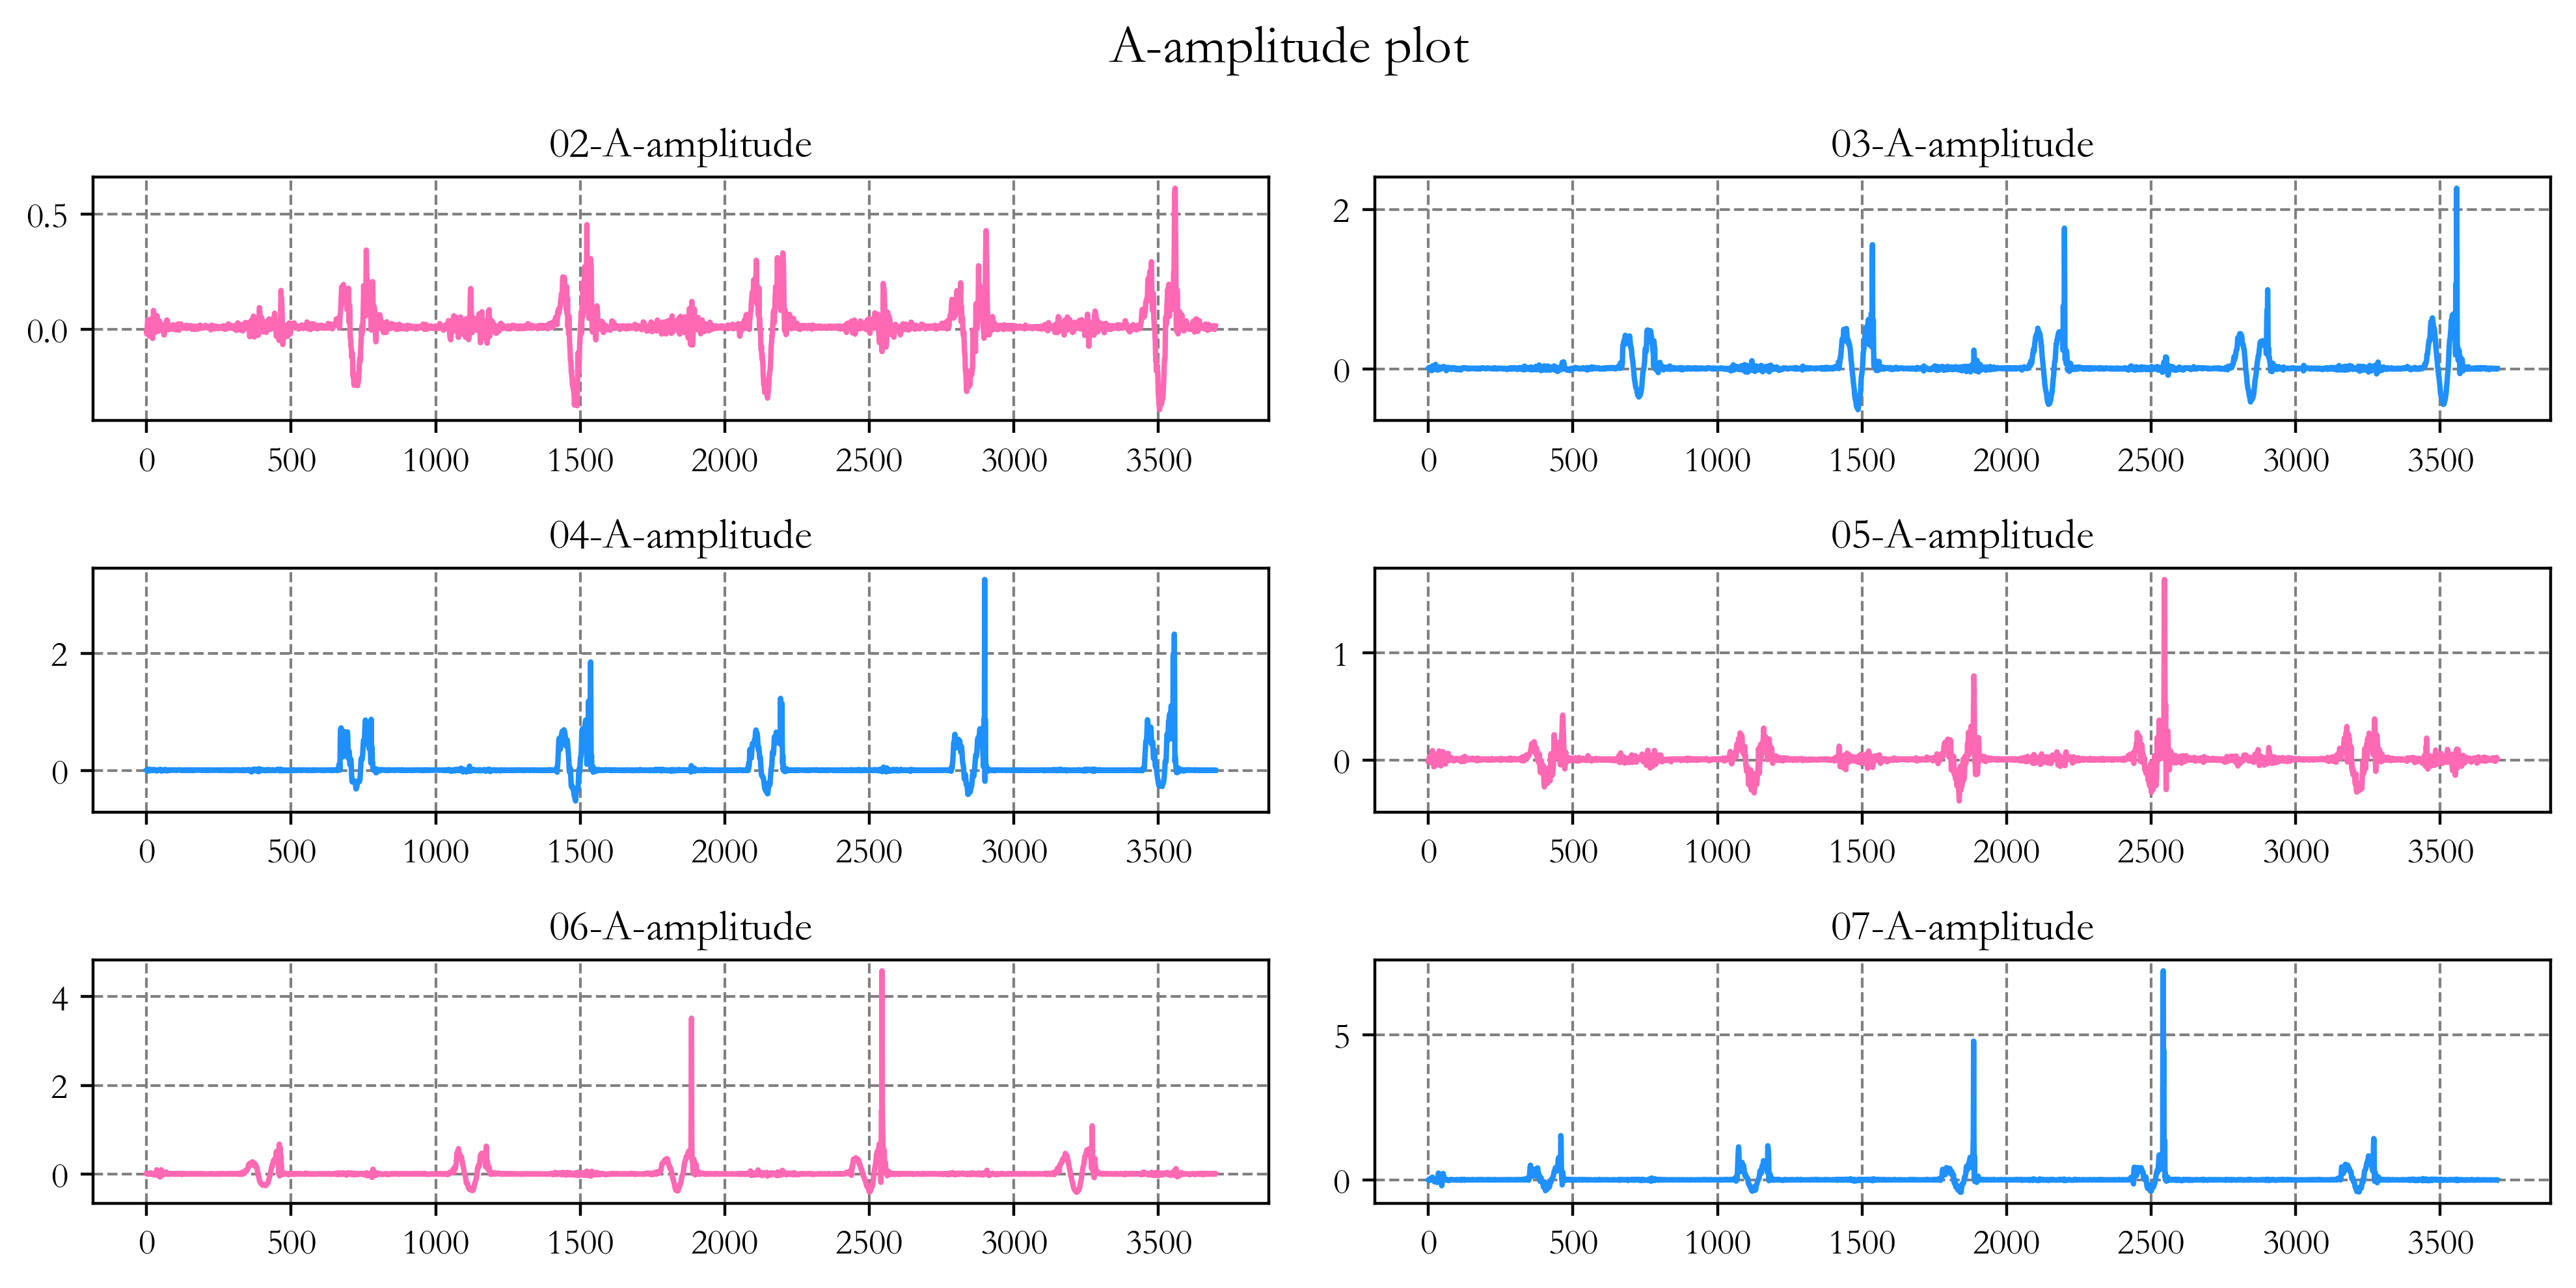

In [318]:
# 调整子图纵向间隔
plt.subplots_adjust(hspace=0.8)
fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(nrows=3, ncols=2, figsize=(10,5))

ax1.plot(amplitude1, linewidth=1.5, color='hotpink')
ax2.plot(amplitude2, linewidth=1.5, color='dodgerblue')
ax3.plot(amplitude3, linewidth=1.5, color='dodgerblue')
ax4.plot(amplitude4, linewidth=1.5, color='hotpink')
ax5.plot(amplitude5, linewidth=1.5, color='hotpink')
ax6.plot(amplitude6, linewidth=1.5, color='dodgerblue')

ax1.set_title('02-A-amplitude')
ax2.set_title('03-A-amplitude')
ax3.set_title('04-A-amplitude')
ax4.set_title('05-A-amplitude')
ax5.set_title('06-A-amplitude')
ax6.set_title('07-A-amplitude')

plt.suptitle('A-amplitude plot', fontsize='15')
ax1.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax1.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax2.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax2.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax3.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax3.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax4.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax4.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax5.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax5.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)
ax6.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75)
ax6.grid(True, which="minor", linestyle=":", color="lightgray", linewidth=0.75)

# ax1.legend();ax2.legend();ax3.legend();ax4.legend();ax5.legend();ax6.legend()

plt.tight_layout()

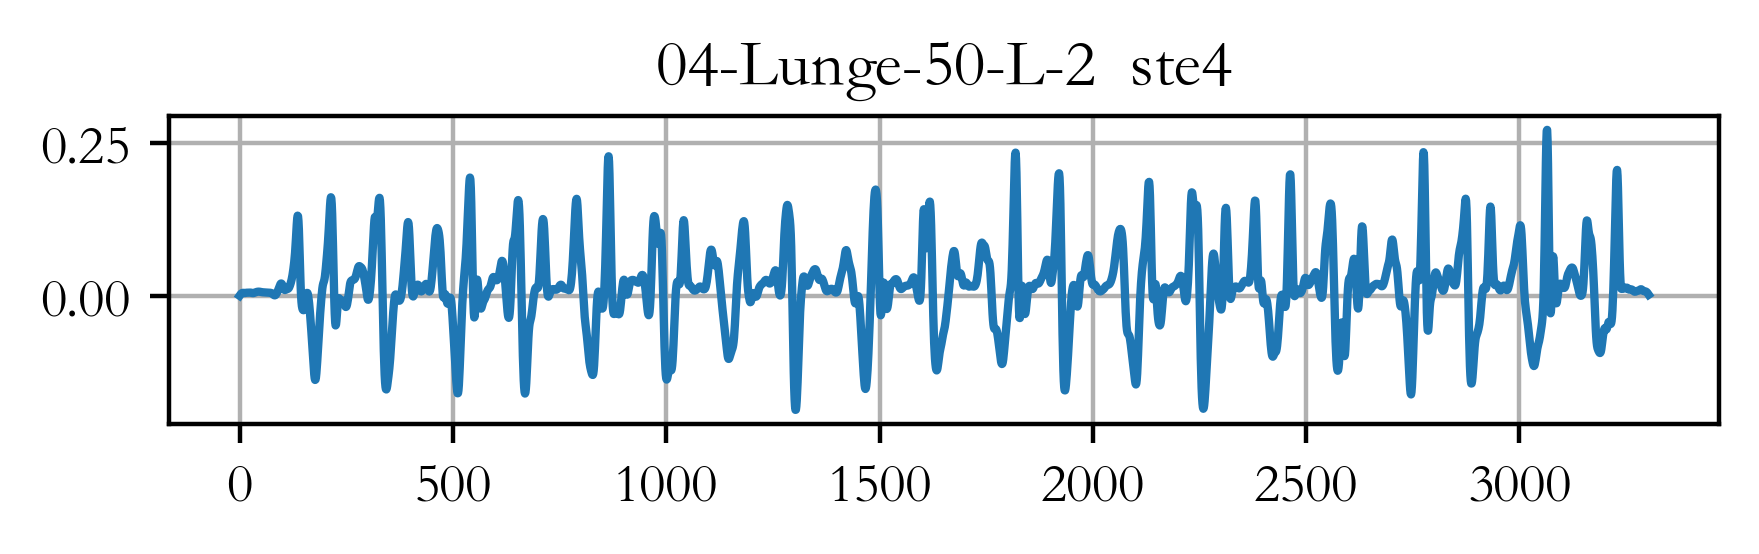

In [235]:
frequency = np.array(96)
values = amplitude.values
target_frequency = np.array(100)

# 查看最后加速度幅值分割情况
plt.rcParams['figure.figsize'] = [5, 1]
plt.title(file_type + '  ' + name, fontsize=12)
plt.plot(amplitude)
plt.grid()

In [55]:
type(amplitude), type(amplitude.values)

(pandas.core.series.Series, numpy.ndarray)

In [236]:
import numpy as np

def linear_interpolation(frequencies, values, target_frequency):
    interpolated_values = []
    
    for freq, value in zip(frequencies, values):
        if freq == target_frequency:
            interpolated_values.append(value)
        else:
            # 插值计算
            pass
            
    return np.array(interpolated_values)

# 示例数据
frequencies = np.array([96, 96, 96])   
values = np.array([10, 20, 30])
target_frequency = 100

# 计算插值结果
interpolated_values = linear_interpolation(frequencies, values, target_frequency)

print(interpolated_values)

[]


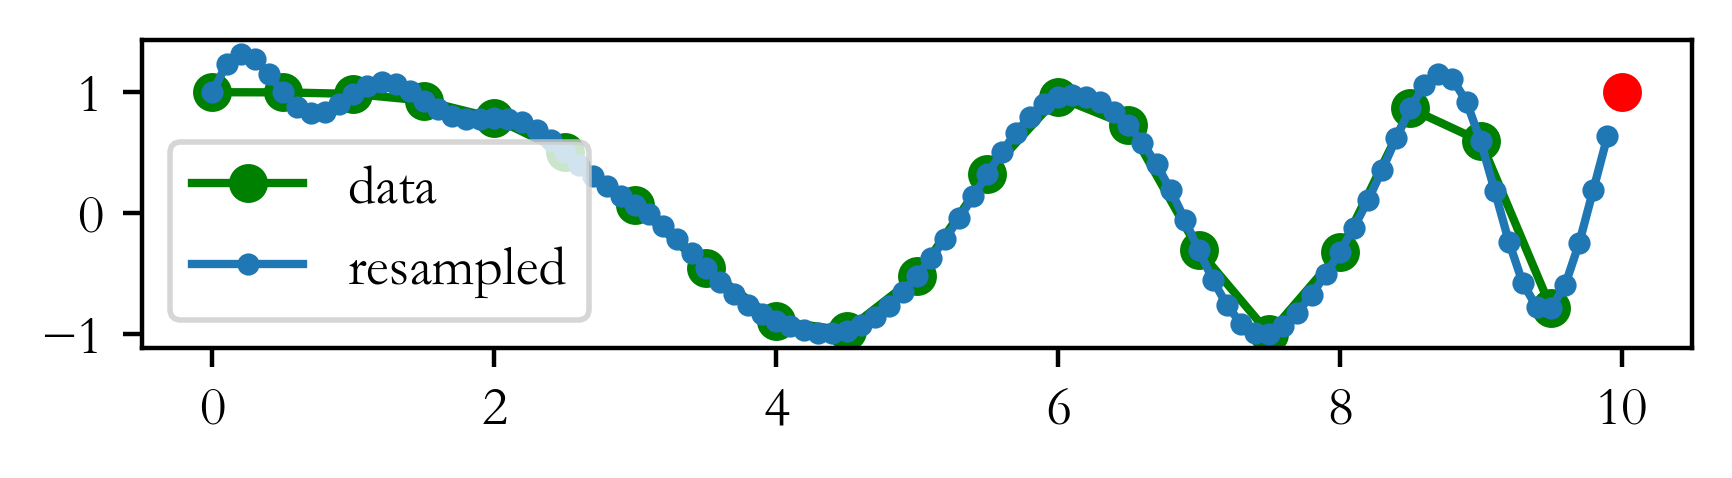

In [237]:
import numpy as np
from scipy import signal
x = np.linspace(0, 10, 20, endpoint=False)
y = np.cos(-x**2/6.0)
f = signal.resample(y, 100)
xnew = np.linspace(0, 10, 100, endpoint=False)
import matplotlib.pyplot as plt
plt.plot(x, y, 'go-', xnew, f, '.-', 10, y[0], 'ro')
plt.legend(['data', 'resampled'], loc='best')
plt.show()